<a href="https://colab.research.google.com/github/sm02-08/misophonia/blob/main/Misophonia2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Misophonia Audio Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all required modules

In [ ]:
import IPython.display as ipd # displays all things like images/audio/video
import librosa # music and audio analysis
import librosa.display # visualizing audio for spectrograms and waveforms and stuff
import pandas as pd # dataframe sand series
import os, time, warnings # interact w/ operating system, working w/ time stuff, warning msgs in code
import seaborn as sns # helps with graphics
import numpy as np # arrays and matrices and math operations
from tqdm import tqdm # progress bars
import ast # processing python abstract syntax trees
import matplotlib.pyplot as plt # plotting visualizations
from sklearn.model_selection import train_test_split # splits data into training/testing, etc
from sklearn.preprocessing import LabelEncoder # preprocessing data (scaling, normalization, encoding)
from sklearn.model_selection import GridSearchCV # for cross validation to tune hyperparameters
import tensorflow as tf # imports tensorflow library for building/training ML models
from tensorflow.keras.utils import to_categorical # can convert labels to one-hot encoding
from tensorflow.keras.models import Sequential # classes & functions for training neural networks
from tensorflow.keras.layers import ( # many neural network layers to build models
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)
warnings.filterwarnings("ignore")

In [ ]:
col_names = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns = col_names)

## Dimensions of the Data
This dataset contains 2,196 samples of audio data, evenly distributed among trigger and non-trigger sounds. The audio was converted to MFCC data before this, and this dataset is all the MFCC data used.

In [ ]:
dataset_path = '/content/drive/MyDrive/Misophonia/misophonia_2000'
metadata = pd.read_csv("/content/drive/MyDrive/Misophonia/misophonia_2000/mfccs_output_2000.csv")
# metadata = metadata[:10]
metadata.head()

,label,filename,0,1,2,3,4,5,6,7,8,9,10,11,12
0,trigger,662557__troube__eating-sounds.wav,-468.43555,48.805527,-57.195866,-115.338036,-82.135315,61.805004,11.603683,22.160671,-14.972826,23.657818,27.529018,-26.177750,-14.364082
1,trigger,f0158_0_sneeze.wav,-263.25748,231.840350,-22.368137,-114.080430,-68.821670,-28.524403,-19.972622,-27.490368,-45.302353,-38.452656,-6.920148,-2.448899,-20.409985
2,trigger,f0010_0_sigh.wav,-564.92550,116.854690,-62.300568,-113.898930,-56.346770,8.877184,-0.562742,-11.906944,17.568455,25.064793,17.704807,-1.359214,-8.927174
3,trigger,f0287_0_sigh.wav,-429.77124,84.831880,-103.592155,-112.394940,-75.458470,70.500200,9.536808,-1.822528,30.580357,24.344913,22.145714,-52.624100,-3.153942
4,trigger,f0287_0_sigh.wav,-433.31412,86.575500,-102.238900,-111.734830,-71.016890,68.243200,10.472345,1.223950,31.222336,29.295940,21.679832,-59.220070,-5.951216


In [ ]:
metadata.shape # number of individual frames

(421772, 15)

## Import the MFCC CSV Data

I used VSCode to transform all my audio files to MFCC data, and into a csv file. I used Librosa to extract the MFCC data, cleaned out any audio that isn't a .mp3 or .wav file, and exported it into two folders: trigger and non-trigger. This is what's used for my audio classification.

In [ ]:
mfcc_csv_path = "/content/drive/MyDrive/Misophonia/misophonia_2000/mfccs_output_2000.csv"
mfcc_data = pd.read_csv(mfcc_csv_path)

This is how many frames were in each section, not how many audio files.

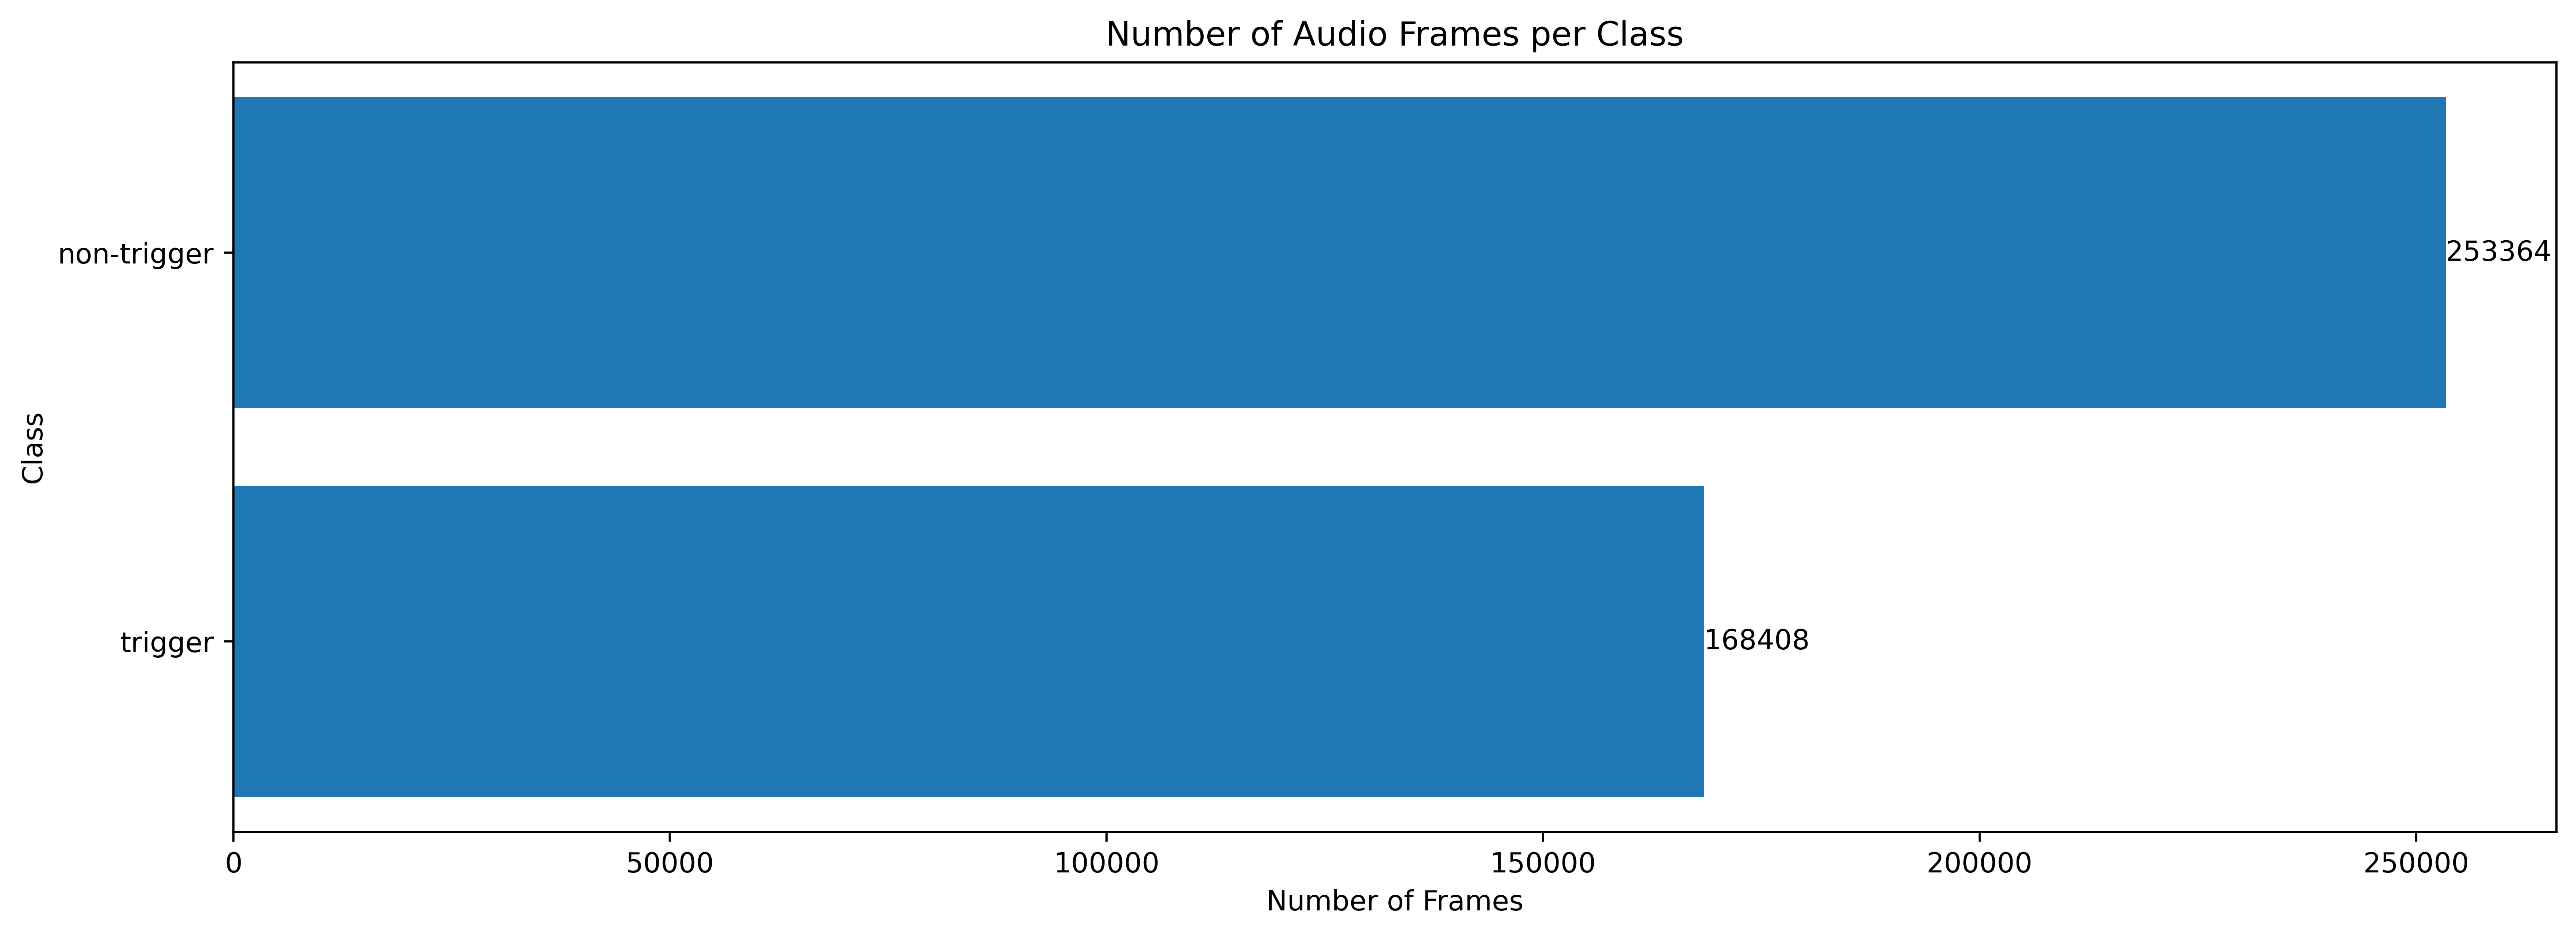

In [ ]:
x = metadata["label"].unique()
y = metadata["label"].value_counts(ascending=True)
ind = np.arange(len(y))
# plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(x)
ax.bar_label(ax.containers[0])
plt.gcf().set_dpi(500)
plt.title("Number of Audio Frames per Class")
plt.xlabel("Number of Frames")
plt.ylabel("Class")
plt.show()

## Extracting the MFCC Data

In [ ]:
!pip install resampy
import resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.2 MB/s eta 0:00:00


This extracts all the number data from the CSV file into multiple arrays which can be used.

In [ ]:
extracted = []

grouped_data = mfcc_data.groupby(["filename", "label"]) # group by filename and label

for (file_name, final_class_labels), group in tqdm(grouped_data):
    # extract MFCC features from the two groups and find the mean
    mfcc_features = group.iloc[:, 2:14].values  # first 2 columns are "filename" and "label"
    scaled_feature = np.mean(mfcc_features, axis = 0) # this basically copmutes the mean of the MFCC features along the rows; axis = 0 just means the rows. axis = 1 means columns
    # scaled_feature = 1D array containing all mean MFCC features for the groups
    # summary: mean is computed for each column (MFCC coefficient) across all rows (frames)

    extracted.append([scaled_feature, final_class_labels]) # store the grouped_data mfcc features & labels

100%|██████████| 2196/2196 [00:00<00:00, 4076.18it/s]


In [ ]:
print(extracted) # snippet of it all

[[array([-640.04558324,   74.75500565,    0.9035766 ,   16.9363551 ,
         10.5329047 ,    0.72283132,   -4.38074469,   -4.30279443,
        -14.95037901,   -3.87967287,    1.11035726,   -4.13619591]), 'non-trigger'], [array([-603.40373185,   68.97529911,  -11.50927269,   10.65036591,
         -5.55518587,   -4.76787004,   -6.7899355 ,  -10.90185378,
         -5.02849803,   -1.13441861,   -5.97790955,   -2.52641821]), 'non-trigger'], [array([-567.42897626,   73.47408689,   -3.47951916,   13.79892376,
          5.4946089 ,   -3.20297801,  -15.59410602,   -8.62193003,
         -4.08482144,  -11.04694854,   -2.53073219,   -3.37626105]), 'non-trigger'], [array([-633.69755952,   58.47237586,   -9.90725327,   12.22681125,
         -5.67993017,   -6.70723165,   -8.90407888,  -17.26784484,
         -9.95752675,   -4.9040212 ,   -4.42632506,   -9.64679644]), 'non-trigger'], [array([-7.13433428e+02,  6.83609392e+01,  7.98917088e+00,  1.51397908e+01,
        1.17157748e+01,  4.30982759e-01,  1

In [ ]:
# previous code
"""
    for subfolder in ["trigger", "non-trigger"]:
        file_path = os.path.join(dataset_path, subfolder, file_name)
        print(file_path)
        if os.path.exists(file_path):
            # Found the file!
            print(f"FOUND!: {file_name}\n")
            break  # Exit the inner loop
        else:
            # Loop completed without finding the file
            print(f"File not found: {file_name}\n")
            continue  # Skip to the next file
"""

'\n    for subfolder in ["trigger", "non-trigger"]:\n        file_path = os.path.join(audio_dataset_path, subfolder, file_name)\n        print(file_path)\n        if os.path.exists(file_path):\n            # Found the file!\n            print(f"FOUND!: {file_name}\n")\n            break  # Exit the inner loop\n        else:\n            # Loop completed without finding the file\n            print(f"File not found: {file_name}\n")\n            continue  # Skip to the next file\n'

### Creating a New Dataframe
This new dataframe is created from the `extracted` list with 2 classes: trigger and non-trigger.

All the MFCC data from each audio file is put into here in the "feature" column.

The DataFrame was stored in a pickle file so that it could be used in the future, as it serializes the DataFrame and allows it to be saved to disk and loaded later.

In [ ]:
extracted_df = pd.DataFrame(extracted, columns = ["feature", "class"]) # create a new dataframe
extracted_df.to_pickle("extracted_df.pkl") # pickling it for further processing
extracted_df[100:112] # specifically looking for the non-triggers

,feature,class
100,"[-732.3915970689654, 74.41759266666666, 9.9572...",non-trigger
101,"[-680.2946238297873, 57.9230423179078, -4.2897...",non-trigger
102,"[-665.2258979545456, 88.2460568310606, 8.52175...",non-trigger
103,"[-706.9209576923078, 71.82814606217948, 13.182...",non-trigger
104,"[-749.6956429411765, 75.01427738257352, 15.362...",non-trigger
105,"[-531.4193244805195, 56.9107801538961, -8.8525...",non-trigger
106,"[-736.9347764539008, 63.03777364184397, 24.437...",non-trigger
107,"[-625.1536364084507, 67.27618479266198, -0.128...",non-trigger
108,"[-728.0853095104894, 81.58203613454545, 7.9868...",non-trigger
109,"[-640.0123177884616, 59.31378460721154, 0.9752...",non-trigger


In [ ]:
extracted_df.shape

(2196, 2)

In [ ]:
final = pd.DataFrame(extracted, columns = ["feature", "class"])
X = np.array(final["feature"].tolist())
y = np.array(final["class"].tolist())

**Label Encoding**

Label encoding converts string labels to numerical values, which allows machine learning algorithms to work better.

For example, the classes ["sniffle", "sneeze", "cough"] might turn into [1, 2, 3].

-

**One-Hot Encoding**

Basically converting integer labels to one-hot encoded foramt, representing them as binary vectors.

So 3 classes would look like this:

0 turns into [1, 0, 0]

1 turns into [0, 1, 0]

2 turns into [0, 0, 1]

-

*Label encoding* converts string labels to integers, while *one-hot encoding* converts the integers to binary vectors.

In [ ]:
le = LabelEncoder() # this makes an instance of the LabelEncoder class, transforming string labels
# to integers

Y = to_categorical(le.fit_transform(y))
# fit learns the unique categories in the string labels (aka y, which is like ['sniffle', 'sneeze'])
# transform turns them into [0, 1, 2]
# to_categorical converts the integers to one-hot encoded format

Train-test split:
The data is split into the classic 80/20, where 80% is used for training and 20% for testing.

Within the 20%, it's split into 50% test and 50% validation.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split( # split into 80% train, 20% test
    X, Y, test_size = 0.2, random_state = 42) # random_state sets a seed for RNG (reproducability); basically just ensures consistency in this specific data randomization.
# 42 = the answer to everything
# without random_state, the train test sets would be different every time

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42) # split temporary set into valid & test sets

# print the details
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_val.shape[0])
print("Number of testing samples:", X_test.shape[0])

Number of training samples: 1756
Number of validation samples: 220
Number of testing samples: 220


## Importing the ANN Model
Artificial Neural Networks (ANNs)

The ANNs use the ReLU activation function, which outputs the input value only if it is positive; otherwise, it returns zero. It's great for sparsity and is computationally efficient, but worse with non-linear data because its sparsity is only achieved through ridding its non-linear understanding ability. However, it helps mitigate the vanishing gradient problem, making training faster. CNN1D also uses this activation function.

This model has 8 layers; it has the input layer, 6 dense layers (from 750 to 50 units), and one output layer.

---

A **dense layer** is a fully connected layer where each neuron is connected to every neuron in the previous layer.
* Dense layers are used to learn features and patterns from the input data.

--

Each layer increases the depth of the model, and extracts different levels of features from the input data (feature extraction).
* Additionally, more layers increase the model's capacity to fit the data.

--

The **softmax** activation function converts the raw output scores into probabilities, ensuring that output probabilities sum to 1 (so that it's suitable for multi-class classification). The model will output a probability distribution over the classes, indicating a likelihood of each class.

Think about softmax like this:
* If 2 people vote for cheese, 7 people vote for pepperoni, and 1 person votes for veggie pizza, this is 20%, 70%, and 10%.
* This is basically what softmax does -- it takes the scores and turns them into probabilites that add up to 1 (aka 100%).

Thus, the softmax function helps the model understand which option is the most likely.

In [ ]:
!pip install scikeras = 0.10.0

# Import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
model_ann = Sequential() # initializes a sequential model, which creates a linear stack of layers
# using keras sequential API
model_ann.add(Dense(128, activation = "relu", input_shape = (X_train.shape[1],))) # X_train.shape[1] gets the number of features
# dense = fully connected layer
# this adds a dense layer with 128 units and a ReLU activation function
# X_train.shape[1] specifies the input shape (aka # of features in training data)

model_ann.add(Dense(750, activation = "relu"))
model_ann.add(Dense(500, activation = "relu"))
model_ann.add(Dense(250, activation = "relu"))
model_ann.add(Dense(100, activation = "relu"))
model_ann.add(Dense(50, activation = "relu"))

# all of these above basically just add multiple dense layers with different #s of units, all with a ReLU activation function
# these add complexity to the model
num_labels = y_train.shape[1] # num_labels is the number of classes in your target variable
model_ann.add(Dense(num_labels, activation = "softmax"))
# this adds the output layer with the # of units equal to the # of classes in the target variable and a softmax activation function
# softmax = multi-class classification; outputs a probability distribution over the classes
model_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 750)                 │          96,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         375,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,416 (2.40 MB)

 Trainable params: 629,416 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the ANN model.

The loss used here is categorical cross-entropy loss. The loss function aids the model in assigning higher probabilities to correct class(es) while reducing probabilities for incorrect classes.
* Essentially, it measures the difference between the truth vs predicted labels, and minimizes differences to ensure accuracy.

--

The ANN model uses an Adam (Adaptive Moment Estimation) optimizer, which is efficient for large amounts of data.

The Adam optimizer accelerates the gradient descent algorithm, through using the "exponentially weighted averages" of the gradients. Essentially, Adam adjusts how big or small the steps are based on how the learning is going. This makes learning faster and more accurate.

In [ ]:
model_ann.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])  # configures the model for training

In [ ]:
param_grid = {
    'batch_size': 32,
    'epochs': [50, 100, 150]
}

100 epochs ensures good results while not being overloading on GPU.

--

**Batch size** is the number of training samples used in one forward & backward pass through a neural network.
* Essentially: Since this has a batch size of 32, the model processes 32 samples at a time before updating the model's parameters.

**Simple analogy:** Count 10 skittles at one time, instead of counting the entire jar.

--

**Gradient update** is hte process of adjusting the model's weights and biases based on computed gardients.
* This minimizes the loss function.

Essentially, the model takes predictions, calculates the loss, and the gardients of the loss are computed using backpropogation.
* The gradients indicate the direction/magnitude of adjustments needed to minimize losses.

**Simple analogy:** If you want to draw a perfect circle, you keep trying and looking back at your previous drawings to fix your mistakes.
* Each time you make a correction, you're making your drawing better.

--

**Samples per Gradient Analogy**
* If you want to know the average color of all jellybeans in a jar, you look at them in *batches* (like 32 at a time), figure out the average color for that batch, and update your guess for the average color of the whole jar (changing little by little).

**SUMMARY:** Taking small groups to make continuous improvements.

In [ ]:
epoch_num = 100 # iterations over the entire training set
batch_size = 32 # number of samples per gradient update
# ^ these things are the parameters

t0 = time.time() # records time to measure the duration of the training process

ANN_Results = model_ann.fit(
    X_train,
    y_train, # x train and y train does... the training
    batch_size = batch_size, # sets batch size to 32
    epochs = epoch_num, # sets epochs to 100
    validation_data = (X_test, y_test), # uses testing data for validation during training
)

model_ann.save("Model1_ANN.keras") # saves to model called Model1_ANN.keras
print("Training finished & model saved")
train_hist_ann = pd.DataFrame(ANN_Results.history) # stores training history into a pandas DataFrame
train_ann = round(time.time() - t0, 3)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 525ms/step - accuracy: 0.5147 - loss: 3.9075 - val_accuracy: 0.8000 - val_loss: 0.4806
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6877 - loss: 0.6453 - val_accuracy: 0.8182 - val_loss: 0.4230
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4641 - val_accuracy: 0.8227 - val_loss: 0.4648
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.4585 - val_accuracy: 0.7773 - val_loss: 0.4169
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4311 - val_accuracy: 0.7227 - val_loss: 0.5626
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8289 - loss: 0.4055 - val_accuracy: 0.8000 - val_loss: 0.4880
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.3691 - val_accuracy: 0.8682 - val_loss: 0.3972
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.3508 - val_accuracy: 0.8682 

In [ ]:
model_ann.export("Model1_ANN")

Saved artifact at 'Model1_ANN'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138925626396688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622800656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622803120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622069728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622071136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622074656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622075888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622079408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622080640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925622080288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138925621904656: TensorSpec(s

In [ ]:
%pwd

'/content'

In [ ]:
%ls

drive/  extracted_df.pkl  Model1_ANN/  Model1_ANN.keras  sample_data/


In [ ]:
%ls /content/Model1_ANN

assets/  fingerprint.pb  Model1_ANN.keras  saved_model.pb  variables/


In [ ]:
model_ann_wrapped = KerasClassifier(build_fn=model_ann,
                                    model_filepath="/content/Model1_ANN/Model1_ANN.keras",
                                    **param_grid) # Pass hyperparameters directly

# Now use the wrapped model in GridSearchCV
grid = GridSearchCV(estimator=model_ann_wrapped, param_grid={}, cv=3, scoring='accuracy') # No need for param_grid here
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))
keras.layers.TFSMLayer(filepath, call_endpoint="serving_default")

print("Best hyperparameters:", grid_result.best_params_)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=ram://cdaca5c312104e878104a9000241153b.

"loss" and "accuracy" represent training loss/accuracy.

"val_loss" and "val_accuracy" represent the validation accuracy.

This also has evaluating the model's test accuracy.

In [ ]:
test_loss, test_accuracy = model_ann.evaluate(X_test, y_test) # not only training + validation; also test

train_hist_ann = train_hist_ann[1:]
train_hist_ann

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8883 - loss: 0.6465 


,accuracy,loss,val_accuracy,val_loss
1,0.707289,0.640654,0.818182,0.422952
2,0.796128,0.459542,0.822727,0.464752
3,0.802961,0.448070,0.777273,0.416877
4,0.825740,0.410647,0.722727,0.562611
5,0.831435,0.423414,0.800000,0.488040
...,...,...,...,...
95,0.972665,0.066258,0.859091,1.070345
96,0.976651,0.062756,0.881818,1.071923
97,0.961845,0.104981,0.850000,1.137769
98,0.962984,0.103123,0.872727,0.962930


### Loss and Accuracy (ANN)
This model uses categorical, or multiclass, cross-entropy loss. Loss is unitless, but it is a measure of the error/difference between the predicted output of the model and the actual output.
The validation loss is the difference between the predicted output and the actual result of data the model hasn't seen, since it uses a validation dataset.

The accuracy is simply how accurately the model classifies the audio -- we have two classes: non-trigger and trigger. The accuracy is how well or correctly the model can classify audio into one of these two classes.
The validation accuracy is how accurately the model can classify data it hasn't seen before, using the validation dataset.

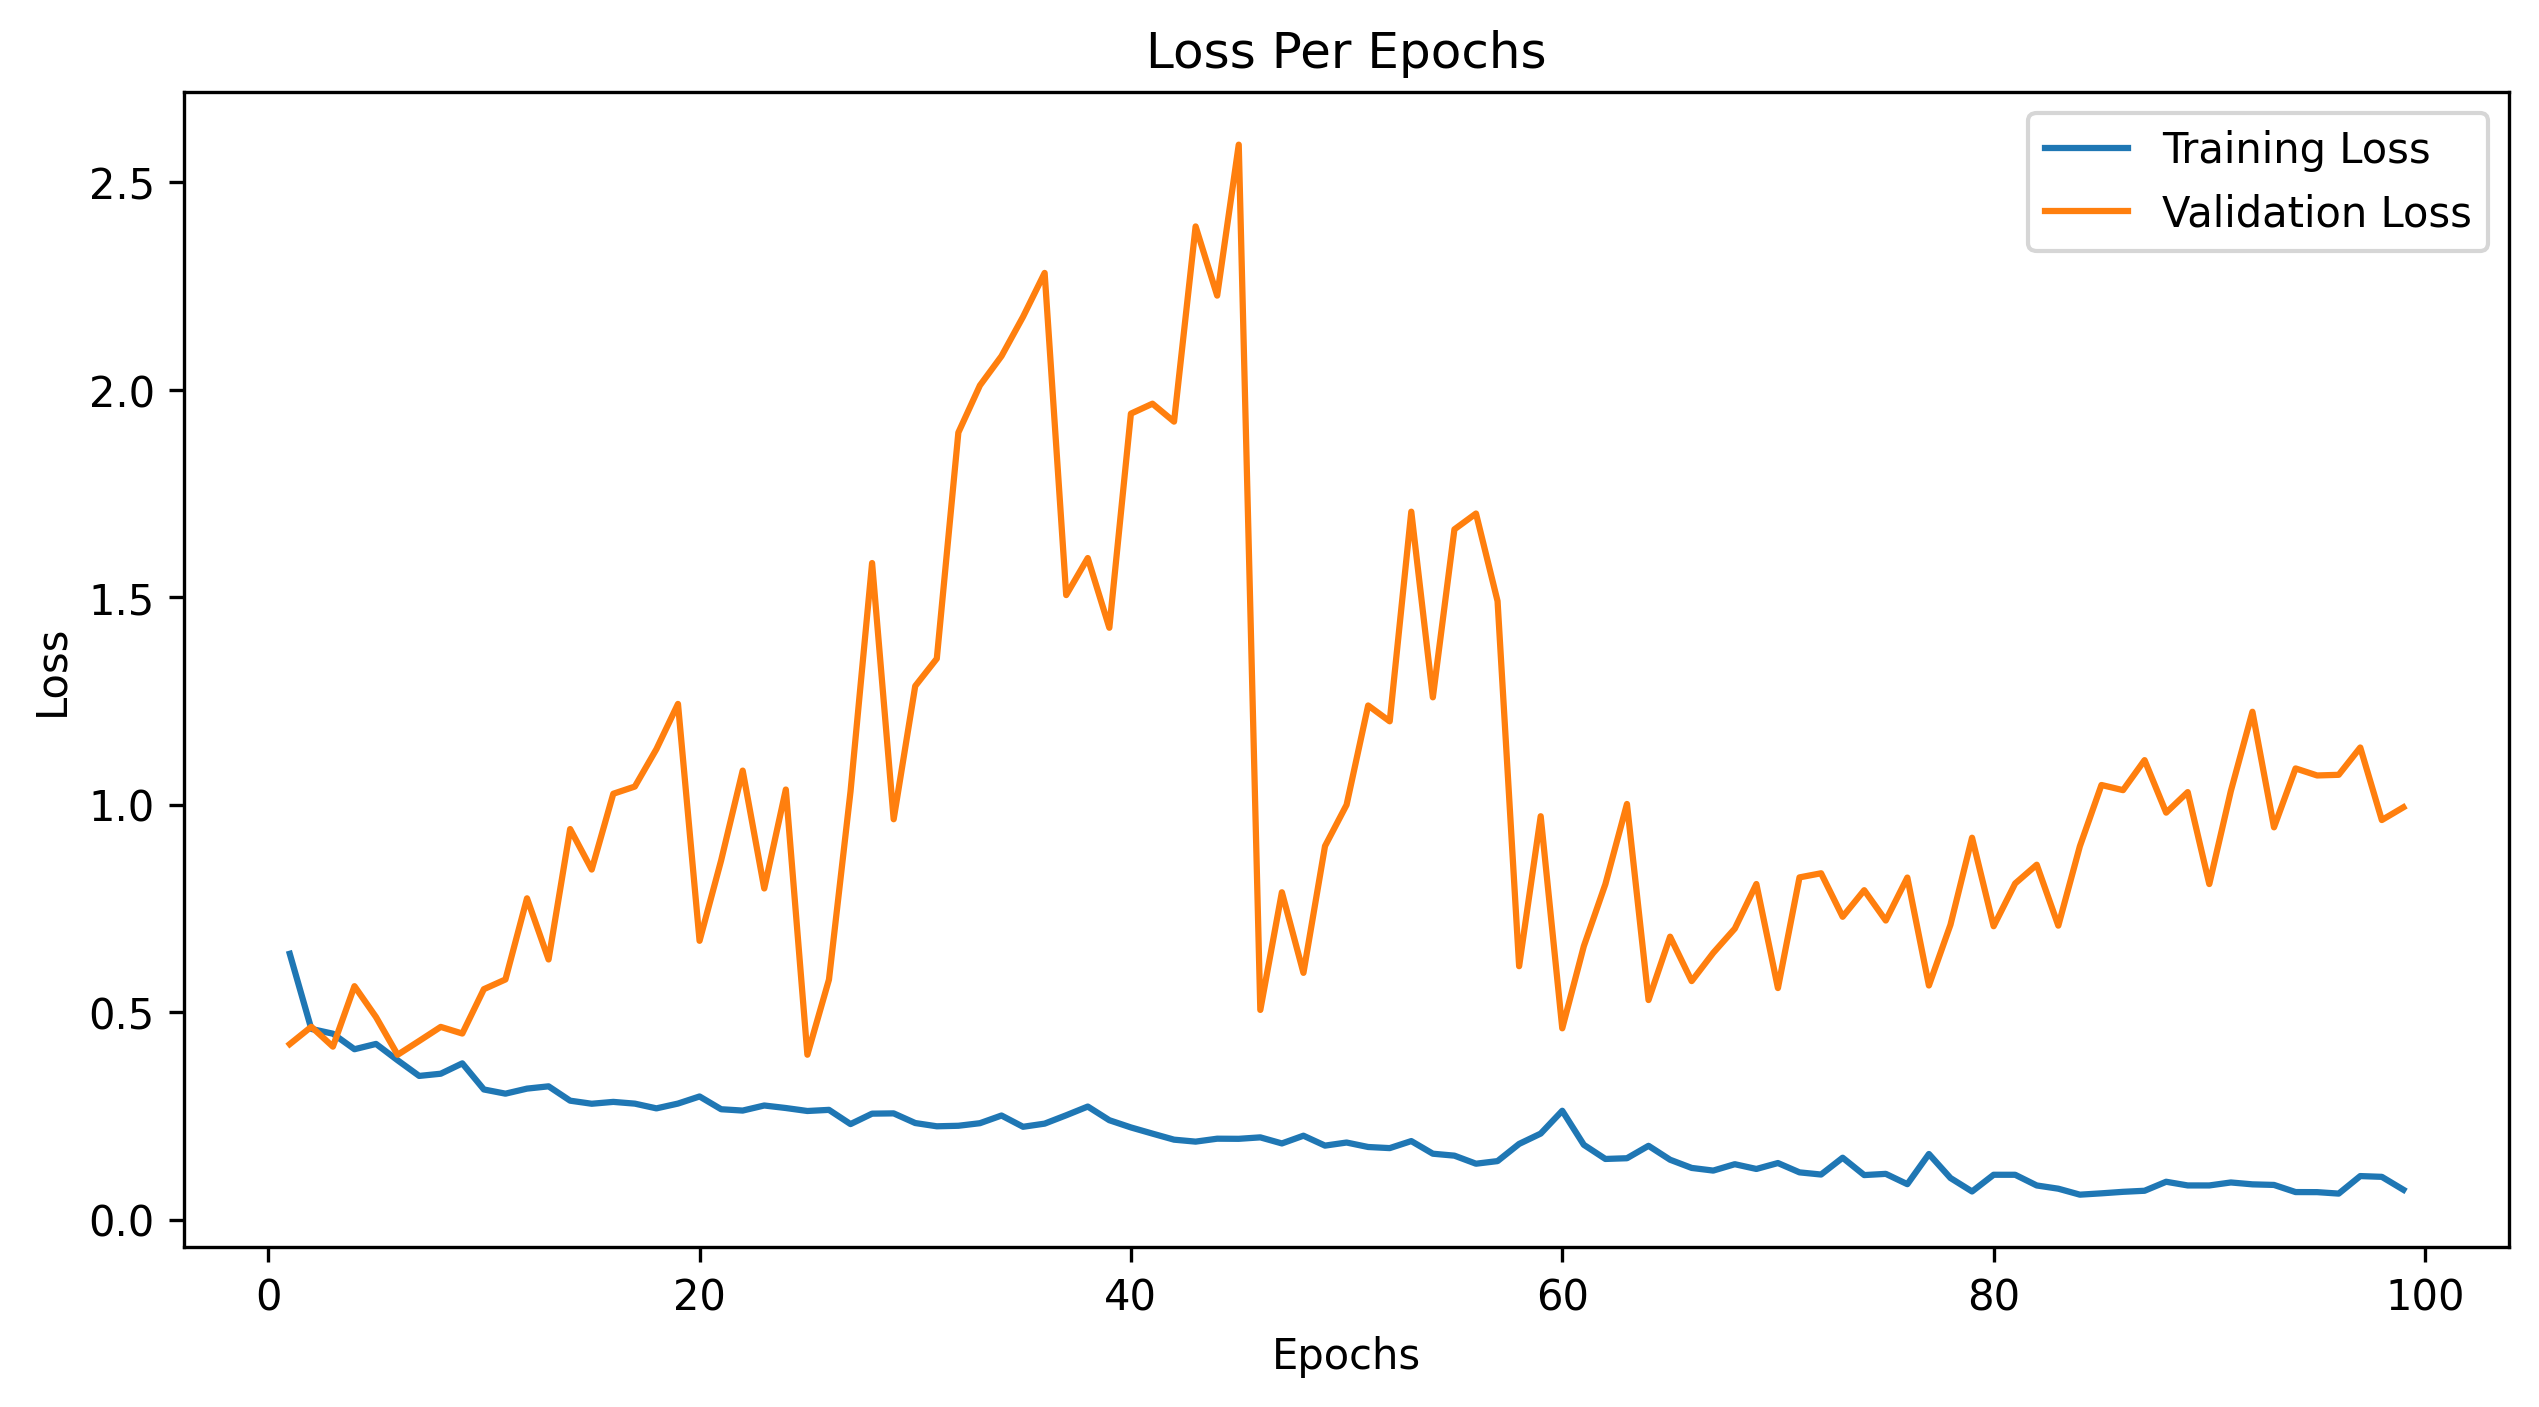

In [ ]:
plt.figure(figsize = (10, 5), dpi = 300) # 10 inches wide, 5 inches tall, 300 dots per inch resolution size
plt.plot(train_hist_ann[["loss", "val_loss"]])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

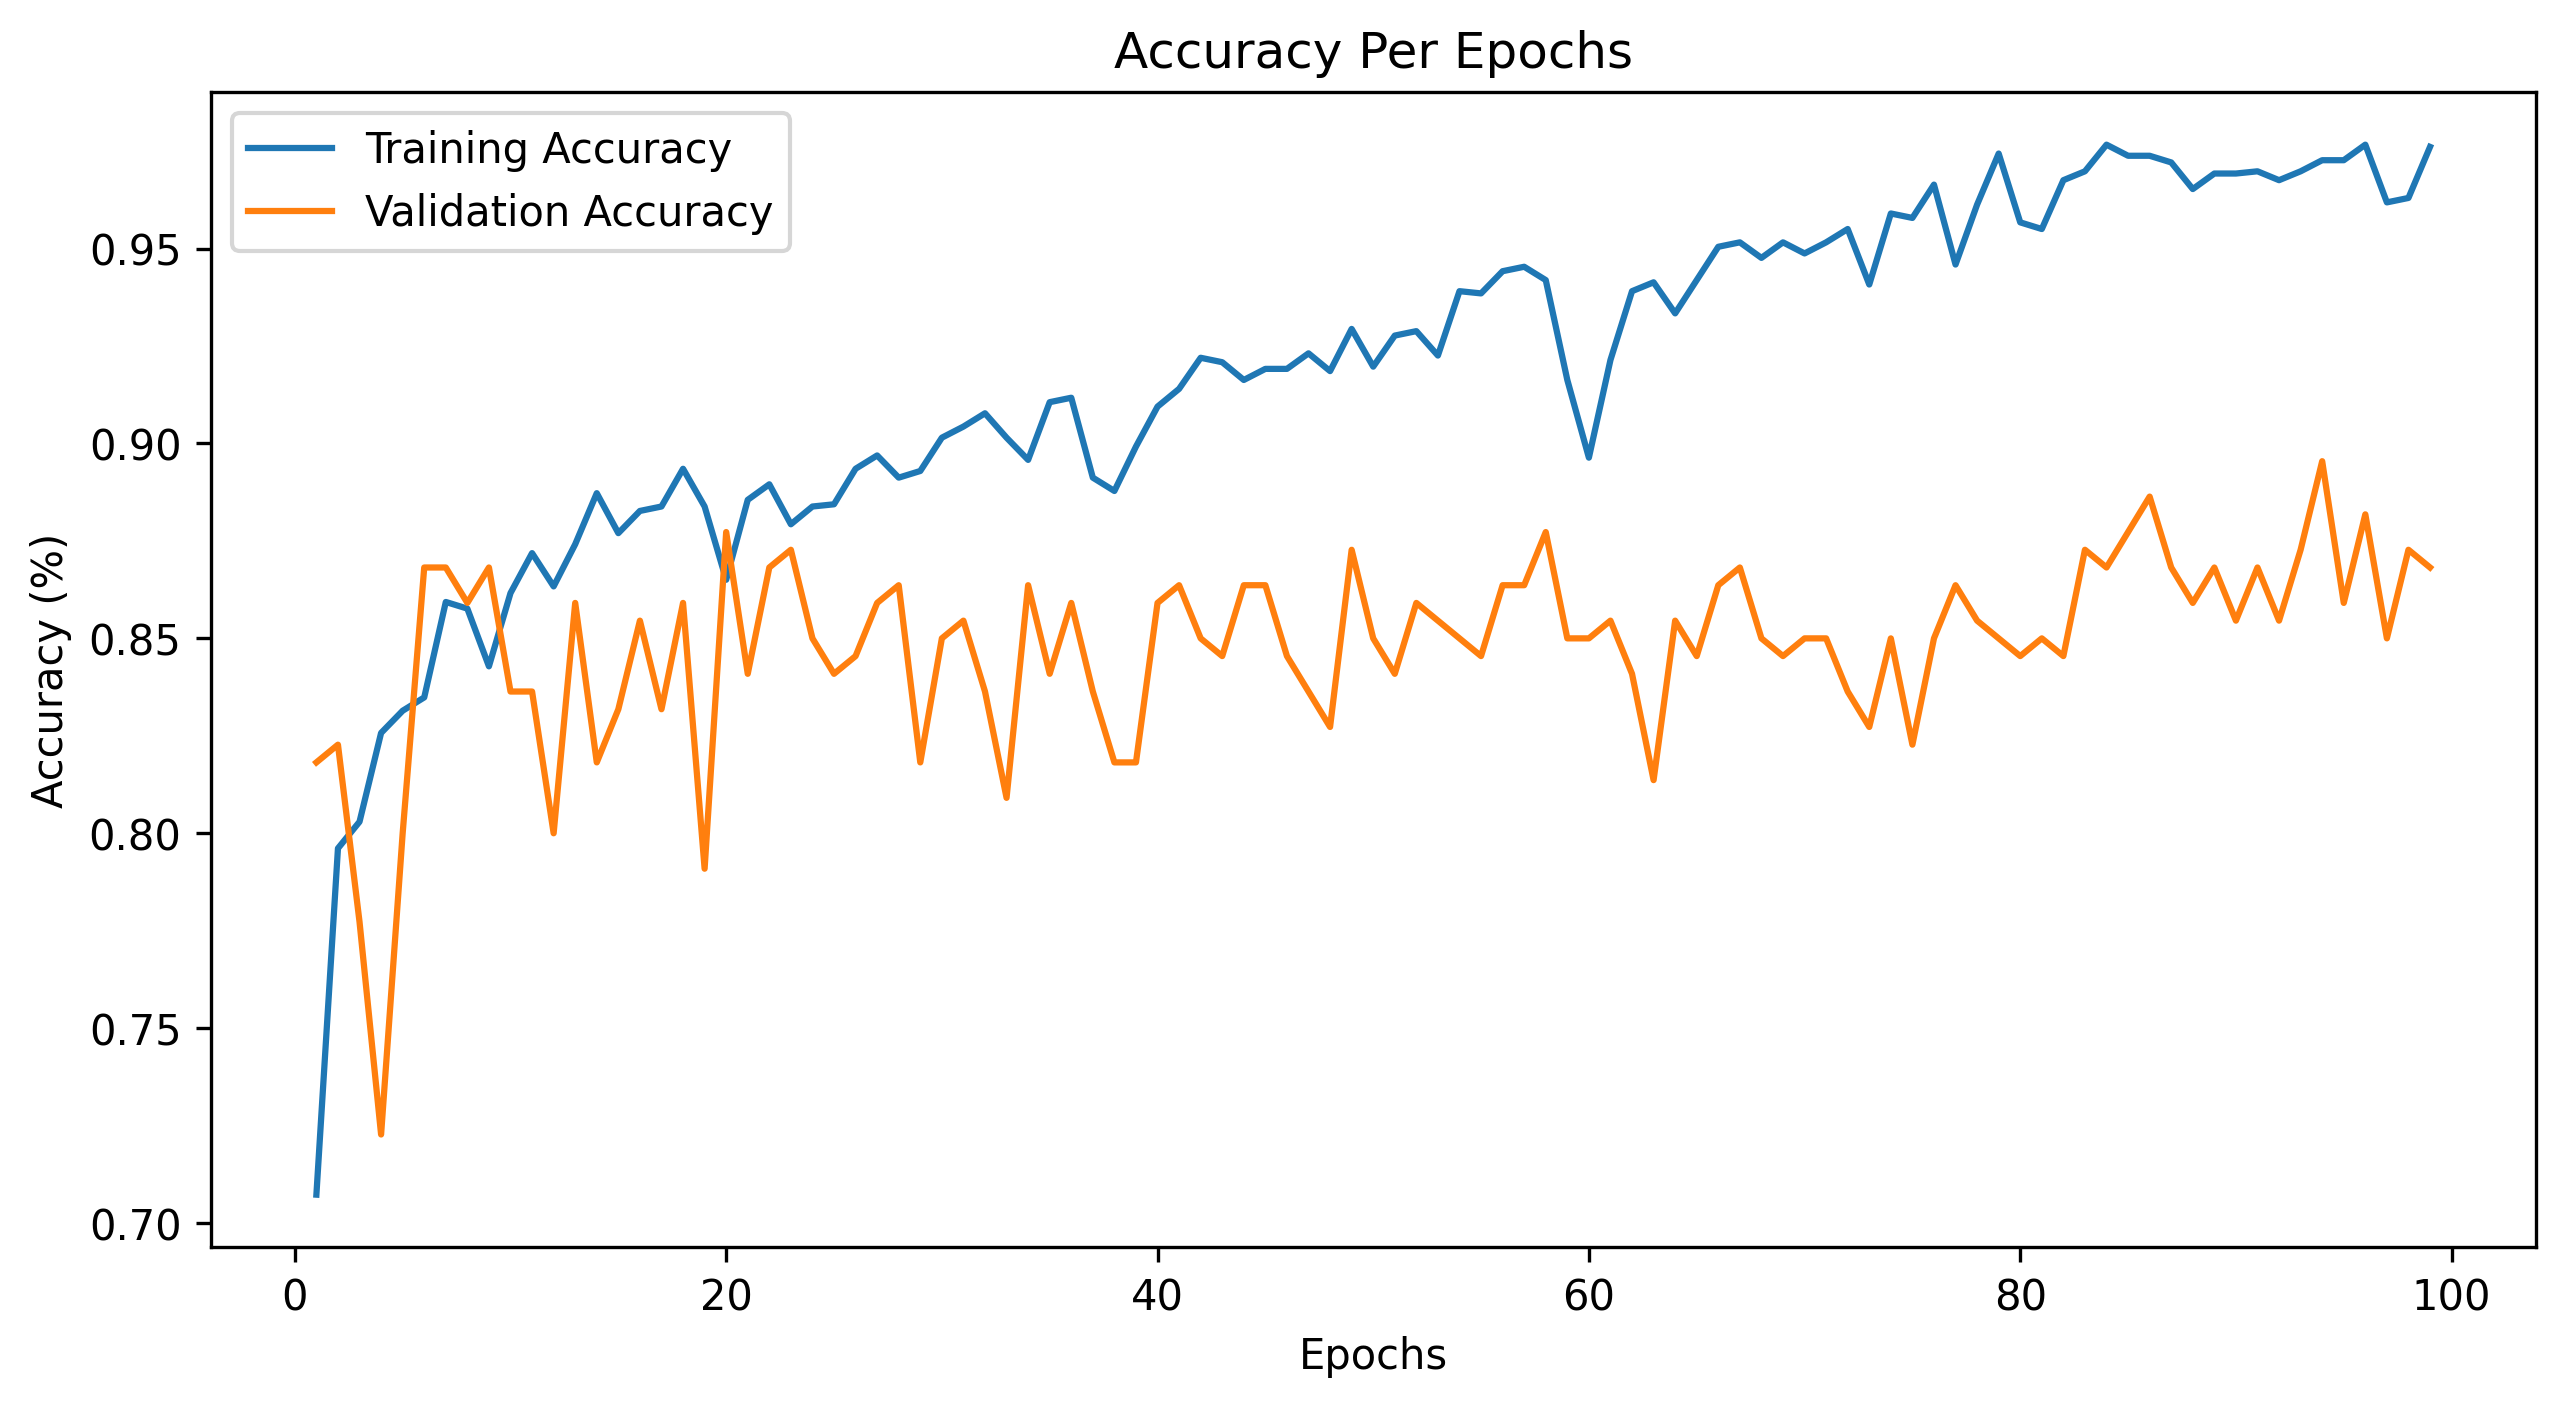

In [ ]:
plt.figure(figsize = (10, 5), dpi = 300)
plt.plot(train_hist_ann[["accuracy", "val_accuracy"]])
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
print("Training Loss:", train_hist_ann["loss"].values[-1])
print("Training Accuracy:", train_hist_ann["accuracy"].values[-1])

print("\n")

print("Validation Loss:", train_hist_ann["val_loss"].values[-1])
print("Validation Accuracy:", train_hist_ann["val_accuracy"].values[-1])

print("\n")

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.07199907302856445
Training Accuracy: 0.9760820269584656


Validation Loss: 0.9936362504959106
Validation Accuracy: 0.8681818246841431


Test Loss: 0.9936362504959106
Test Accuracy: 0.8681818246841431


### Evaluating the Model

After finishing the results, a new log entry was put into the dataframe, evaluating the ANN model's accuracy, prediction time, and results.

In [ ]:
accuracy_ann = model_ann.evaluate(X_test, y_test, verbose=0) # evaluates based on test data; verbose=0 means it won't print any output during evaluation
t0 = time.time() # records time before making predictions
y_pred_ann = model_ann.predict(X_test, verbose=0) # predicts labels for the X_test data, but doesn't print output
pred_ann = round(time.time() - t0, 3) # calculates time taken to make predictions; rounds to 3 decimals
log_entry = pd.DataFrame( # makes new dataframe with results, specified by col_names.
    [["ANN", accuracy_ann[1] * 100, train_ann, pred_ann]], columns = col_names # row contains model name, accuracy of model on test data (%), training time, and prediction time
)
log = pd.concat([log, log_entry], ignore_index=True) # concatenates the log entry to the existing log dataframe (ignores index to have continuous index)

### Sample Audio
This displays an example of the code, where we showcase how the model works on one audio file and see whether it gets it correct. This example is a sniffling audio file.

---

`feature_scaled = np.mean(feature.T, axis = 0)`
* When we extrct features from the audio data, we get a matrix: each row represents a different feature, each column represents a different time.
* Transpose this matrix = swap rows and columns.
* Then, calculate the mean value for each feature across all time frames.

**Result:** single value for each feature, basically summarizing the feature's behavior over the entire clip.
* This is because the time row and feature column (since they were transposed) lead to one value inside.
* This reduces dimensionality.
---
`predicted_vector = np.argmax(model_ann.predict(prediction_feature), axis = -1)`
* When the ANN model makes a prediction, it outputs a *probability distribution* for all possible classes. (Again, a probability distribution is like 20% of people wanted cheese pizza while 80% wanted pepperoni.)
* Each value in this output represents the model's confidents that the input belongs to a particular class.
* `argmax` identifies the index of the highest value (aka the highest confidence in predicted probability) -- basically the class the model thinks is the most likely.
* The index is now the predicted class ID.

Example: The model outputs [0.1, 0.2, 0.7].
* The argmax function returns `2` since that's the index of the 3rd value, and the highest probability (70%).

In [ ]:
def ann_pred(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast") # load audio file specified by file_name
    # res_type specifies resampling type (kaiser_fast)
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=12) # extracts mfcc features; makes sure to extract 12
    feature_scaled = np.mean(feature.T, axis = 0) # scales features by taking the mean of the transpopsed feature matrix along the rows
    prediction_feature = np.reshape(feature_scaled, (1, -1))  # reshapes scaled features to a 2D array // 1 row, -1 infers the # of columns based on the original size
    predicted_vector = np.argmax(model_ann.predict(prediction_feature), axis = -1) # finds index of the maximum value along the specified class (predicted class ID)
    predicted_class = le.inverse_transform(predicted_vector) # converts predicted class ID back to class label (uses label encoder)
    print("ANN has predicted the class as  --> ", predicted_class[0])

In [ ]:
file_name = dataset_path + "/trigger/f0003_0_sniff.wav"
print(file_name)
ann_pred(file_name)
ipd.Audio(file_name) # playing the file f0003_0_sniff

/content/drive/MyDrive/Misophonia/misophonia_2000/trigger/f0003_0_sniff.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
ANN has predicted the class as  -->  trigger


## Model 2: CNN1D

The dataset was split into 70% training, 10% test, and 20% validation.

The validation set's purpose is to tune the model's hyperparameters; after each epoch, the model's performance is evaluated on the validation set to monitor the model's accuracy and classification ability.

After the training is done, the test set is used for testing the model's performance.

---

#### Dimensions of the Sets
The shape of `X Train` is (1580, 12, 1).
* The **first** dimension represents the number of samples in the training set.
* The **second** dimension represents the n umber of features for each sample (aka the # of MFCC coefficients, or 12).
* The **third** dimension represents the number of channels. In audio processing, the "channels" basically make the data compatible with neural network layers that expect a specific input shape, and helps process things like audio spectrograms.

The third dimension is usually used when using neural networks.

Having 3 dimensions for `X Train` makes it compatible with CNNs that expect a specific shape of input data.

--

The shape of `X Test` is (220, 12).
* The **first** dimension represents the number of samples in the set.
* The **second** dimension represents the number of features (MFCC coefficients) in each sample.

The test data is not being fed into a CNN or a layer that requires 3D input, so it can stay as 2D.

In [ ]:
xTrainVal, xTest, yTrainVal, yTest = train_test_split(
    X, Y, test_size = 0.1, stratify = y, random_state = 387 # random_state = the value assigned for this specific train-test split data (for reproducability)
) # X and Y are the input features and target labels
# stratify=y means that the split maintains the same proportion of classes as the original dataset
xTrain, xValid, yTrain, yValid = train_test_split(
    xTrainVal, yTrainVal, test_size = 0.2, stratify = yTrainVal, random_state = 387 # 20% of the training data is for the validation set
) # stratify=yTrainVal ensures the split maintains the same proportions of classes as the training data
print("\nNumber of samples for train set:", xTrain.shape[0])
print("Number of samples for validation set:", xValid.shape[0])
print("Number of samples for test set:", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis = 2) # adds new dimension, at the 3rd position (index 2). this matches the input shape expected by CNN1D.
xValid = np.expand_dims(xValid, axis = 2)

print("Shape of xTrain:", xTrain.shape)
print("Shape of xTest:", xTest.shape)

# One-hot encode the labels
# if you get shape (0, 2, 2), just comment these 3 out and rerun it from here on
# yTrain = tf.keras.utils.to_categorical(yTrain, num_classes = 2)
# yValid = tf.keras.utils.to_categorical(yValid, num_classes = 2)
# yTest = tf.keras.utils.to_categorical(yTest, num_classes = 2)


Number of samples for train set: 1580
Number of samples for validation set: 396
Number of samples for test set: 220
Shape of xTrain: (1580, 12, 1)
Shape of xTest: (220, 12)


### Initializing CNN1D

A **sequential model** means the layers will be added one after another.

This model contains:
* 4 convolutional layers
* 1 batch normalization layer
* 4 max pooling layers
* 4 dropout layers
* 1 flatten layer
* 2 dense layers

...for a total of 16 layers.

The output layer has 2 units, representing the 2 classes.

---

#### Key Terms
**Kernel Size:** Size of the filter (kernel) used for the convolutional layer (it slides over the input data to perform convolution operations).
* The kernel is 5 units wide.

**Stride:** Number of units hte filter moves (aka strides) over the input data.
* The stride is 1, meanning hte filter moves one unit at a time.

Essentially, the kernel size is how large the field of the filter is, and stride controls how much the filter overlaps with the input data.

--

The number of **channels** refers to the depth of the input data; it allows the model to process multiple streams of information at once.

--

**Batch normalization** normalizes the activations of the previous layer, stabilizing and speeding up the training process.
* **Analogy:** Using a cookie cutter to make sure all cookies are uniform. Batch normalization makes sure the data goes through each layer balanced and even.

--

**Max Pooling** reduces the dimensionality of the data.
* It takes the maximum value within a specified window (aka the pool size), down-sampling the data while still retaining important features.
* Min pooling takes the minimum value within the window, but max pooling is more commonly used.

**Analogy for Max Pooling:** Focusing on the most important parts when looking at a picture through a magnifying glass.
* Basically, only the most important features are looked at.

Pool size is the size of the window, and stride determines how much the window moves.
* Thus, the size of the data is reduced, and therefore complexity and overfitting are both reduced.
* More pooling layers reduces the sample size progressively.

--

**Flattening** converts the multi-dimensional output of convolutional layers into a 1D vector (the shape was set to 3D, so now it's converted to 1D).
* Only this way can it be fed into a dense layer, since dense layers expect 1D input.
* **Analogy:** Taking a 3D lego house and flattening it, laying all the bricks in a single line (one row of numbers) to feed into the next layer (since they're now easier to count).

In [ ]:
model_cnn1d = Sequential()
model_cnn1d.add(
    Conv1D(
        256, # 256 filters
        5, # kernel size = 5
        strides = 1, # stride = 1
        padding = "same", # each output has the same length as the input
        activation = "relu", # relu activation function
        input_shape=(xTrain.shape[1], 1), # basically the input shape -- xTrain.shape[1] = # of features. "1" is the number of channels
    )
)
model_cnn1d.add(BatchNormalization()) # normalizes activations of previous layer

model_cnn1d.add(MaxPooling1D(3, strides = 2, padding = "same")) # performs max pooling; pool size of 3 and stride of 2. this reduces data dimensionality
model_cnn1d.add(Conv1D(256, 5, strides = 1, padding = "same", activation = "relu")) # adds another 1D convolutional layer; same parameters as before, but different input shape
model_cnn1d.add(Dropout(0.3)) # drops 30% of the neurons randomly during training; this prevents overfitting

model_cnn1d.add(MaxPooling1D(3, strides = 2, padding = "same")) # another max pooling layer to reduce dimensionality even more
model_cnn1d.add(Conv1D(128, 5, strides = 1, padding = "same", activation = "relu")) # 3rd convolutional layer; has 128 filters and same kernel size + activation function
model_cnn1d.add(Dropout(0.3)) # prevents overfitting again

model_cnn1d.add(MaxPooling1D(3, strides = 2, padding = "same")) # 4th pooling layer to reduce dimensionality
model_cnn1d.add(Conv1D(64, 5, strides = 1, padding = "same", activation = "relu")) # 4th convolutional layer w/ 64 filters
model_cnn1d.add(Dropout(0.3)) # overfitting prevention

model_cnn1d.add(MaxPooling1D(3, strides = 2, padding = "same"))
model_cnn1d.add(Flatten()) # flattens the 3D output to a 1D vector; can be fed into a fully connected (aka a dense) layer
model_cnn1d.add(Dense(units = 512, activation = "relu")) # fully connected dense layer; 512 units, relu activation function
# model_cnn1d.add(Dense(units = 1024, activation = "relu"))

model_cnn1d.add(Dropout(0.3))
model_cnn1d.add(Dense(units = 2, activation = "softmax")) # output layer = 2 units for binary classification, and softmax activation to output probabilities
model_cnn1d.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 12, 256)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 256)              │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 3, 128)              │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 2, 64)               │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569,794 (2.17 MB)

 Trainable params: 569,282 (2.17 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
model_cnn1d.compile(
    optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

#### Variables
* The training data was divided into batches of 64 samples each.
* THe model was trained on 50 epochs.
* The validation data was used to evaluate the model's performance after each epoch.

In [ ]:
t0 = time.time() # records current time before starting training process

CNN1D_Results = model_cnn1d.fit( # trains CNN1D using the training data (xTrain and yTrain)
    xTrain, yTrain, batch_size = 64, epochs = 100, validation_data = (xValid, yValid)
)

model_cnn1d.save("Model1_CNN1D.keras")
print("CNN1D Model Saved")
train_hist_cnn1d = pd.DataFrame(CNN1D_Results.history) # converts training history into a pandas dataframe
train_cnn1d = round(time.time() - t0, 3) # calculates total training time by subtracting start time t0 from current time, rounded to 3 decimals

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.5231 - loss: 0.7961 - val_accuracy: 0.5000 - val_loss: 0.8592
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7080 - loss: 0.5736 - val_accuracy: 0.5126 - val_loss: 0.8653
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7893 - loss: 0.4834 - val_accuracy: 0.7601 - val_loss: 0.4966
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8072 - loss: 0.4207 - val_accuracy: 0.7828 - val_loss: 0.4723
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8420 - loss: 0.3896 - val_accuracy: 0.7727 - val_loss: 0.5000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8432 - loss: 0.3733 - val_accuracy: 0.8232 - val_loss: 0.4317
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.3738 - val_accuracy: 0.8434 - val_loss: 0.3801
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.3360 - val_accuracy: 0.8510 -

CNN1D Model Saved


In [ ]:
print("Shape of xTest:", xTest.shape)
print("Shape of yTest:", yTest.shape)

Shape of xTest: (220, 12)
Shape of yTest: (220, 2)


In [ ]:
xTest = xTest.reshape(xTest.shape[0], xTest.shape[1], 1) # reshapes xTest from (220, 12) to (220, 12, 1)
# ^ now compatible with input layer
test_loss_1d, test_accuracy_1d = model_cnn1d.evaluate(xTest, yTest) # not only training + validation; also test

train_hist_cnn1d = train_hist_cnn1d[1:]
train_hist_cnn1d

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.8859 - loss: 0.6412


,accuracy,loss,val_accuracy,val_loss
1,0.737342,0.552163,0.512626,0.865315
2,0.787342,0.478069,0.760101,0.496613
3,0.818987,0.414407,0.782828,0.472298
4,0.843671,0.392898,0.772727,0.500029
5,0.851899,0.369577,0.823232,0.431718
...,...,...,...,...
95,0.956962,0.109246,0.866162,0.484973
96,0.966456,0.090725,0.863636,0.448860
97,0.970886,0.065052,0.866162,0.508437
98,0.976582,0.056850,0.881313,0.636009


### Loss and Accuracy (CNN 1D)
This model uses categorical, or multiclass, cross-entropy loss. Loss is unitless, but it is a measure of the error/difference between the predicted output of the model and the actual output.
The validation loss is the difference between the predicted output and the actual result of data the model hasn't seen, since it uses a validation dataset.

The accuracy is simply how accurately the model classifies the audio -- we have two classes: non-trigger and trigger. The accuracy is how well or correctly the model can classify audio into one of these two classes.
The validation accuracy is how accurately the model can classify data it hasn't seen before, using the validation dataset.

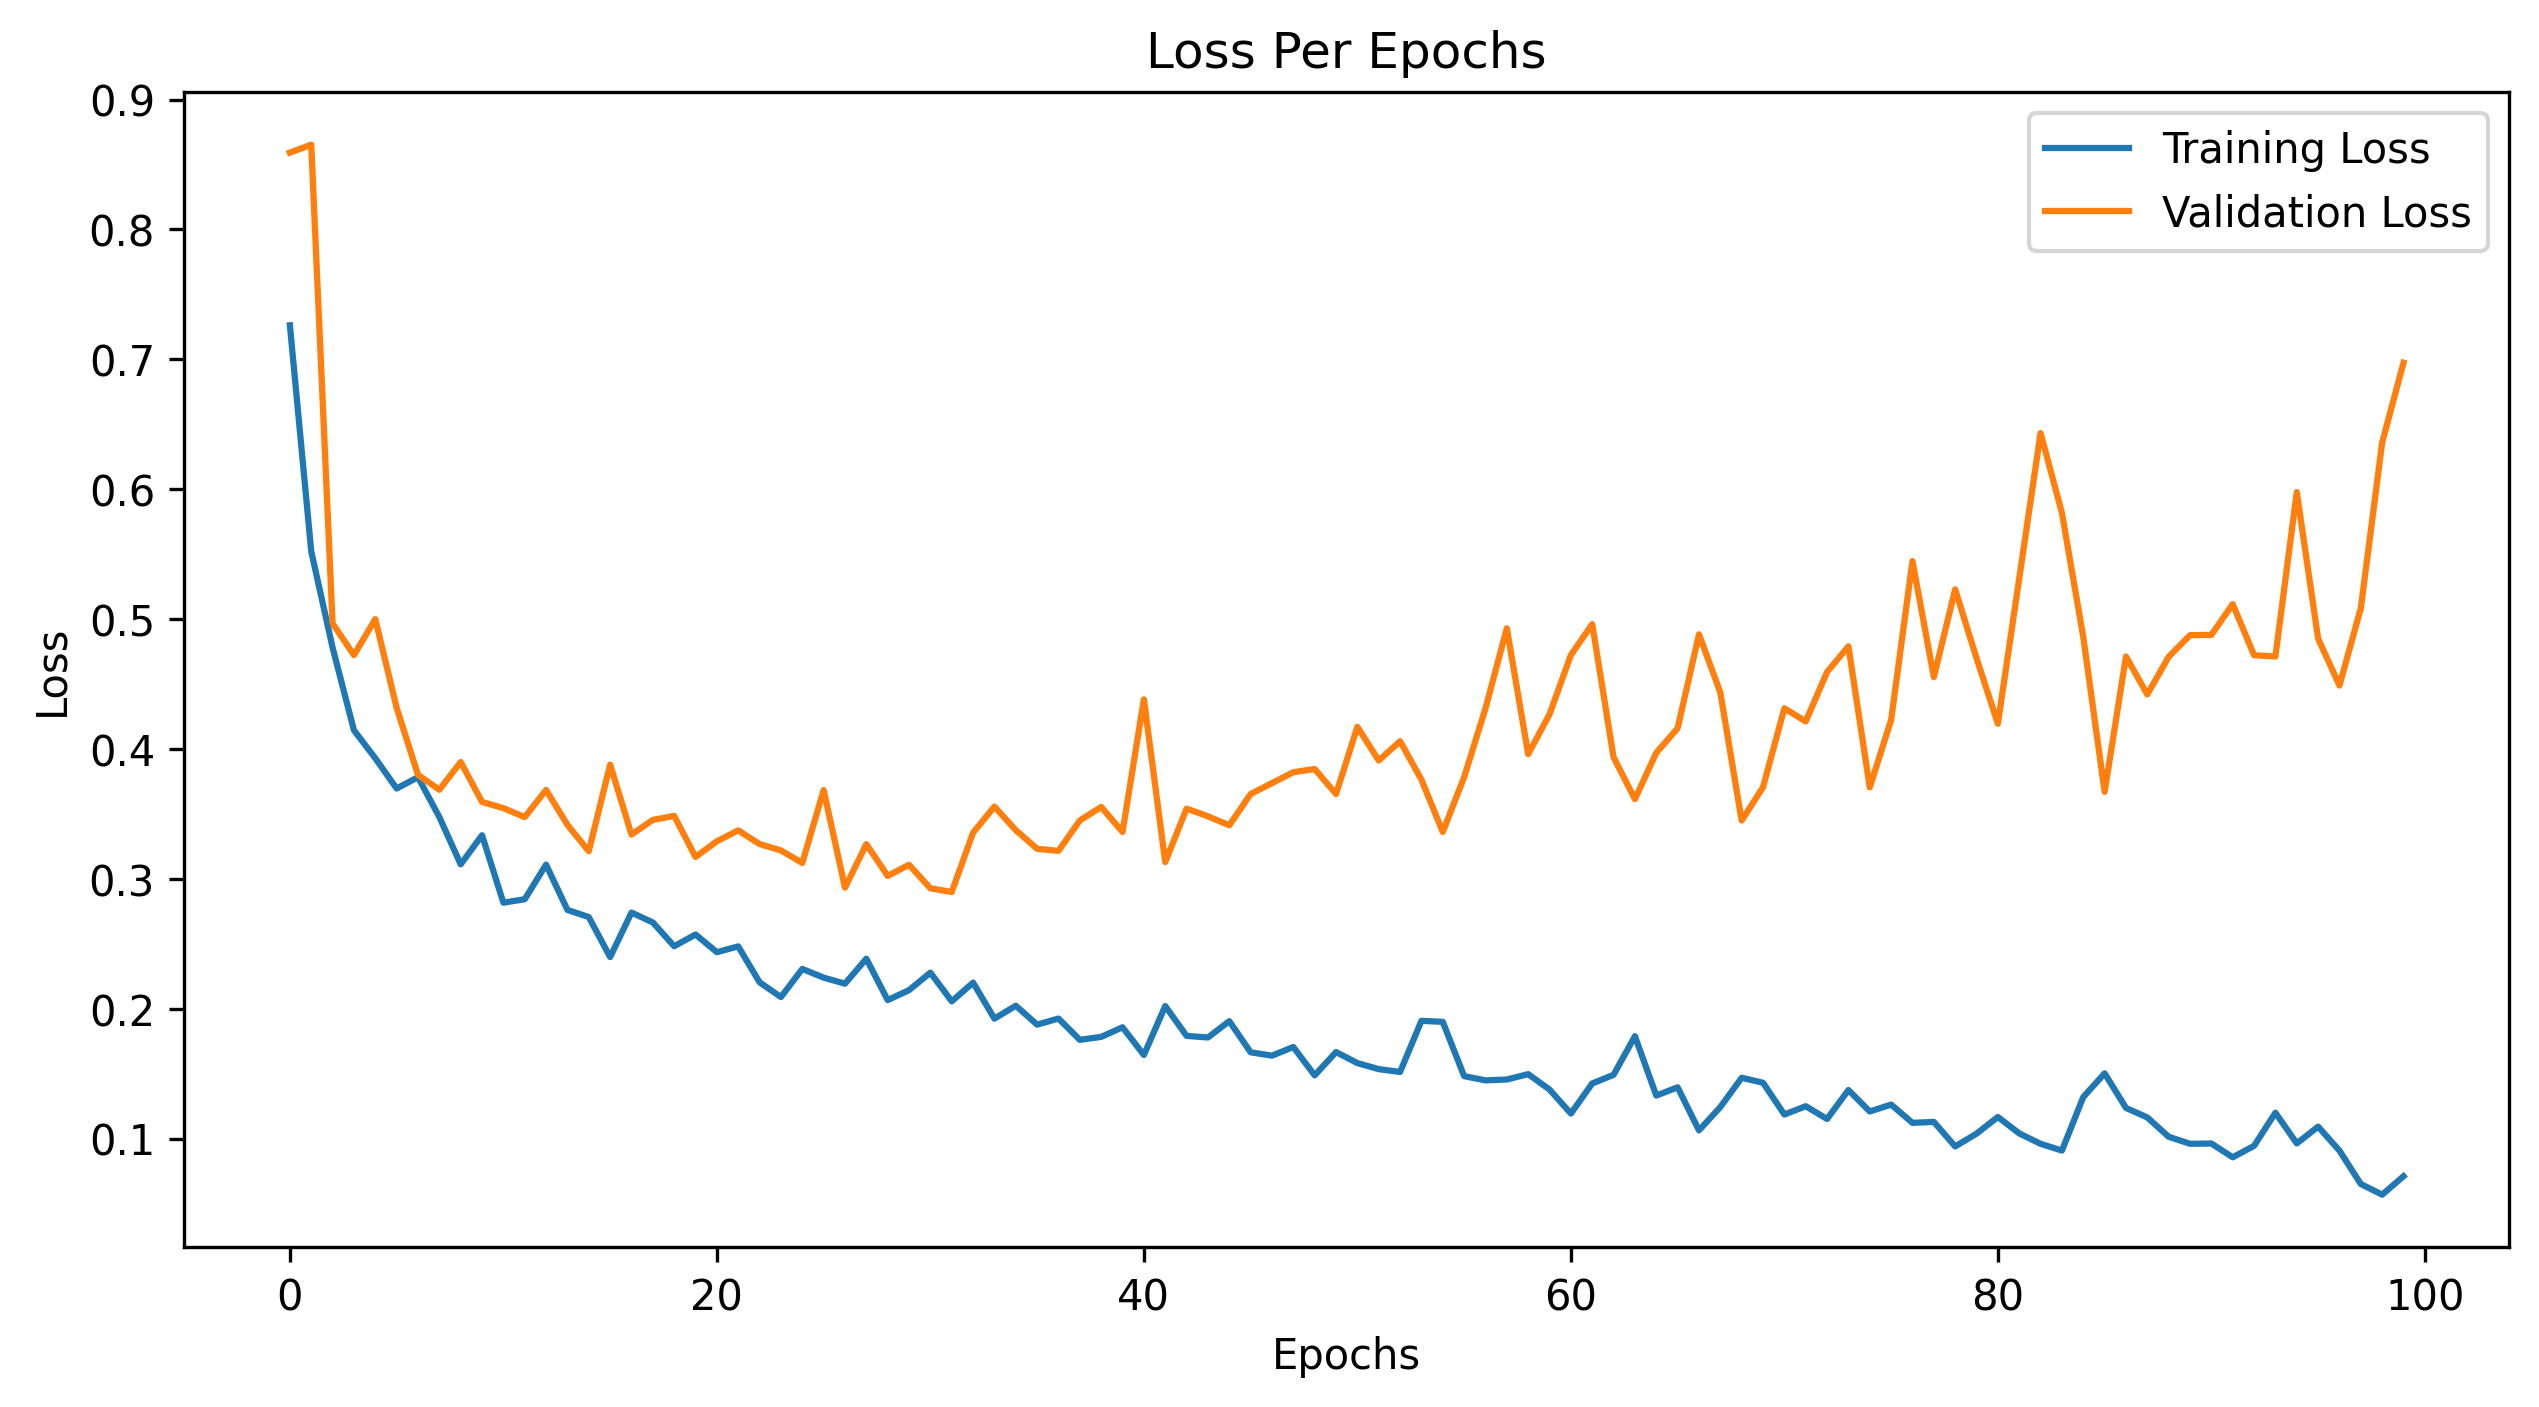

In [ ]:
plt.figure(figsize = (10, 5), dpi = 300)
plt.plot(train_hist_cnn1d[["loss", "val_loss"]])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

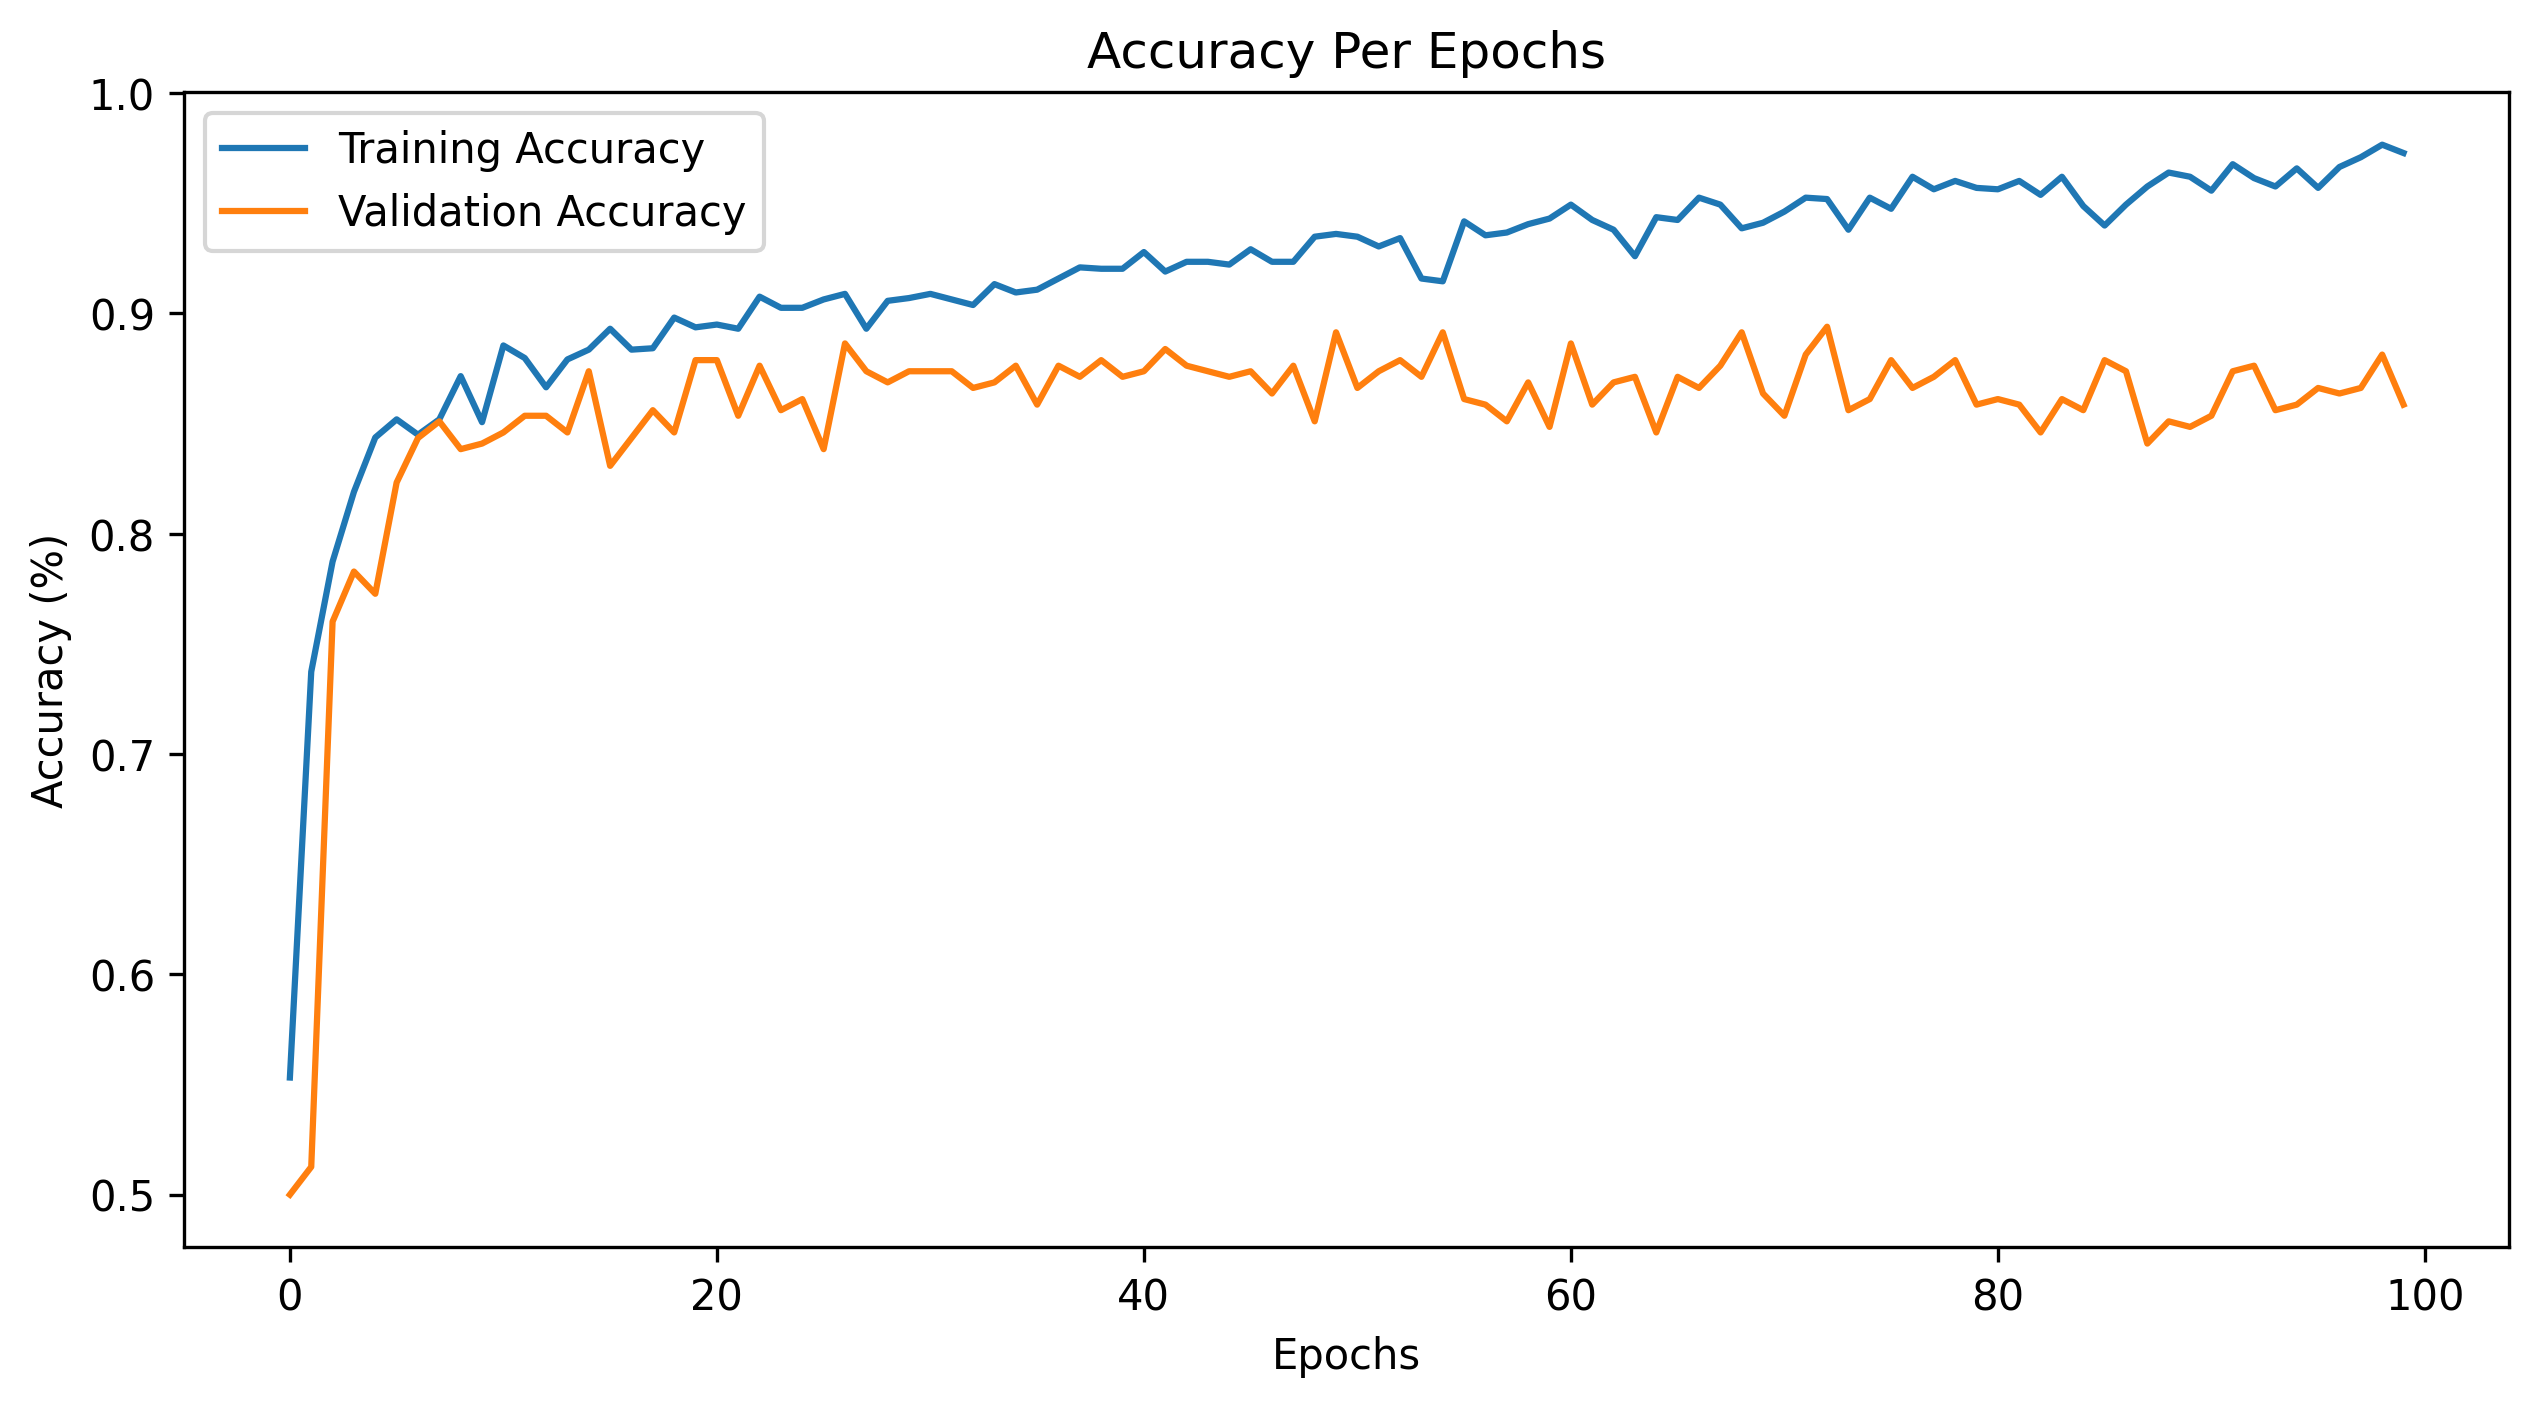

In [ ]:
plt.figure(figsize = (10, 5), dpi = 300)
plt.plot(train_hist_cnn1d[["accuracy", "val_accuracy"]])
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
accuracy_cnn1d = model_cnn1d.evaluate(xValid, yValid, verbose = 0) # .evaluate() evaluates the model on the validation data, returning list of metrics. verbose=0 means it won't print any outputs
t0 = time.time() # records time rn before making predictions
y_pred_cnn1d = model_cnn1d.predict(xValid, verbose = 0) # predicts labels for validation data
pred_cnn1d = round(time.time() - t0, 3) # time taken to make predictions; rounds to 3 decimals
log_entry = pd.DataFrame( # makes new DF with the results
    [["CNN1D", accuracy_cnn1d[1] * 100, train_cnn1d, pred_cnn1d]], columns = col_names # col_names = columns; rows contain model name, accuracy on val data, training time, pred time
)
log = pd.concat([log, log_entry], ignore_index=True) # concatenates it into the DF

In [ ]:
print("Training Loss:", train_hist_cnn1d["loss"].values[-1])
print("Training Accuracy:", train_hist_cnn1d["accuracy"].values[-1])

print("\n")

print("Validation Loss:", train_hist_cnn1d["val_loss"].values[-1])
print("Validation Accuracy:", train_hist_cnn1d["val_accuracy"].values[-1])

print("\n")

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.07103719562292099
Training Accuracy: 0.9727848172187805


Validation Loss: 0.6974466443061829
Validation Accuracy: 0.8585858345031738


Test Loss: 0.9936362504959106
Test Accuracy: 0.8681818246841431


### Predicting the Audio File's Class

Just like with the ANN, this function loads an audio file, extracts its features, scales its features, prepares it for prediction, and then uses the CNN1D model to predict the class of the audio file. Additional information is explained here that wasn't in the ANN's prediction explanation.
* The features used is MFCC data. Features are numerical representations of audio signals that have important characteristics.

---

The **Kaser Fast sampling type** is a resampling method that's fast, but sacrificies a little quality while working.
* Resampling means to change the sample rate of an audio signal.

--

**Extracting** features means to convert the signal into numerical values.

**Scaling** features means to normalize them -- make them have similar ranges.
* The model is therefore able to be more stable, as no single feature dominates the learning process.

**Preparing** features means to reshape and reorganize them into a format that the model can use.

In [ ]:
def cnn1d_pred(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast") # res_type = resampling type
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128) # extracts 128 MFCC features from audio data
    feature_scaled = np.mean(feature.T, axis = 0) # scale the features, resulting in a single value for each feature (summarizing the feature's behavior over the entire audio clip)
    # basically, take all the numbers that represent the features, and find the mean, and use that one value to represent it
    prediction_feature = np.array([feature_scaled]) # array them
    final_prediction_feature = np.expand_dims(prediction_feature, axis = 0) # adds an extra dimension to the array
    final_prediction_feature = np.reshape(final_prediction_feature, (1, 1, 128)) # reshapes the array to match the input shape the model expects
    predicted_vector = np.argmax(model_cnn1d.predict(final_prediction_feature), axis = -1) # argmax returns index of maximum avlue along the specified axis
    # this corresponds to the predicted class ID
    predicted_class = le.inverse_transform(predicted_vector) # converts class ID back to class label (label encoder)

    print("CNN1D has predicted the class as  --> ", predicted_class[0]) # results

In [ ]:
prediction_feature.shape

NameError: name 'prediction_feature' is not defined

In [ ]:
file_name = dataset_path + "/trigger/f0003_0_sniff.wav"
cnn1d_pred(file_name)

ipd.Audio(file_name) # play file

NameError: name 'final_prediction_feature' is not defined

## CNN2D

Reshaping is done to match the input layer expected by the CNN2D.

This data is reshaped to have 4 rows, 3 columns, and 1 channel.

* The **first dimension** is 1580 or 220, representing the number of samples in the training set/test set.
* The **second dimension** is 4, which represents the number of rows for each sample.
* The **third dimension** is 3, which represents the number of columns for each sample.
* The **fourth dimension** is 1, which represents the number of channels for each sample.

Basically, this means you have 1580 samples, and each sample is a 3D array with the dimensions (4, 3, 1).
* 4 dimensions (4D) in total.

In [ ]:
xtrain = xTrain.reshape(xTrain.shape[0], 4, 3, 1) # number of samples in training set; reshapes each sample in the set to have the shape of (trainshape, 4, 3, 1)
# 4 * 3 * 1 = 12 = original 12 MFCCs
xtest = xTest.reshape(xTest.shape[0], 4, 3, 1) # reshapes test set to also have (testshape, 4, 3, 1) shape

print("The Shape of X Train:", xtrain.shape)
print("The Shape of Y Train:", yTrain.shape)
print("The Shape of X Test:", xtest.shape)
print("The Shape of Y Test:", yTest.shape)

The Shape of X Train (1580, 4, 3, 1)
The Shape of Y Train (1580, 2)
The Shape of X Test (220, 4, 3, 1)
The Shape of Y Test (220, 2)


CNN2D differs from the other ones as it uses the tanh activation function. However, "softmax" remains the same.

Tanh: A type of activation function which transforms the input value to a value between -1 and 1. Tanh has an S-shaped curve that is symmetric around zero.
Tanh is usually great for symmetric data.

--

This model contains **8 layers**.
* Two 2D convolutional layers.
* 2 max pooling layers.
* 1 dropout layer
* 1 flatten layer
* 2 dense layers

In [ ]:
model_cnn2d = Sequential() # sequential = layers added one after another
model_cnn2d.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape=(4, 3, 1)))
# ^ 2D convolutional layer; 64 filters; each filter has the size 3x3; padding = same means the output has the same height & width as input
# tanh activation function, an input shape of (4, 3, 1) where 4 = height, 3 = width, 1 = # of channels
model_cnn2d.add(MaxPool2D(pool_size=(2, 2))) # max pooling; pool size of 2x2, reducing the dimensionality of the data; prevents overfitting
# by taking the max value in each 2x2 window
model_cnn2d.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh")) # adds 2nd 2D convolutional layer w/ 128 filters, each size 3x3, tanh activ. func
model_cnn2d.add(MaxPool2D(pool_size=(2, 2))) # another max pooling layer
model_cnn2d.add(Dropout(0.1)) # drops 10% of the neurons randomly to prevent overfitting
model_cnn2d.add(Flatten()) # flattens to a 1D vector so it can be fed into a dense layer
model_cnn2d.add(Dense(1024, activation = "tanh")) # dense is kept at 1024 units; uses tanh activ. func
model_cnn2d.add(Dense(2, activation = "softmax")) # output layer -- 2 unitss for binary classification, softmax activation function to output probabilities
model_cnn2d.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 4, 3, 64)          640       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 2, 1, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 1, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 1, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 2, 1, 128)         0         
                                                                 
 flatten_11 (Flatten)        (None, 256)             

In [ ]:
model_cnn2d.compile(
    optimizer="adam", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

In [ ]:
t0 = time.time() # records current time before starting training

CNN2D_Results = model_cnn2d.fit( # trains using xtrain and ytrain
    xtrain, yTrain, epochs = 50, batch_size=50, validation_data=(xtest, yTest) # 50 epochs, divided into batches of 50 sample each
) # validation data tests the model's performance after each epoch

model_cnn2d.save("Model3.h5")
print("CNN2D Model Saved")
train_hist_cnn2d = pd.DataFrame(CNN2D_Results.history) # converts training history to a pd dataframe
train_cnn2d = round(time.time() - t0, 3) # calculates total training time by subtracting start time from current time; rounded to 3 decimals

Epoch 1/50
32/32 [==============================] - 2s 12ms/step - loss: 0.6644 - accuracy: 0.6690 - val_loss: 0.5055 - val_accuracy: 0.7636
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4076 - accuracy: 0.8114 - val_loss: 0.4436 - val_accuracy: 0.8000
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4205 - accuracy: 0.8146 - val_loss: 0.4101 - val_accuracy: 0.8273
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3409 - accuracy: 0.8576 - val_loss: 0.4268 - val_accuracy: 0.7955
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3162 - accuracy: 0.8671 - val_loss: 0.4123 - val_accuracy: 0.8227
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3093 - accuracy: 0.8753 - val_loss: 0.4630 - val_accuracy: 0.8045
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3202 - accuracy: 0.8671 - val_loss: 0.3977 - val_accuracy: 0.8273
Epoch 8/50
32/32 [=

### Loss and Accuracy (CNN 2D)
This model uses categorical, or multiclass, cross-entropy loss. Loss is unitless, but it is a measure of the error/difference between the predicted output of the model and the actual output.
The validation loss is the difference between the predicted output and the actual result of data the model hasn't seen, since it uses a validation dataset.

The accuracy is simply how accurately the model classifies the audio -- we have two classes: non-trigger and trigger. The accuracy is how well or correctly the model can classify audio into one of these two classes.
The validation accuracy is how accurately the model can classify data it hasn't seen before, using the validation dataset.

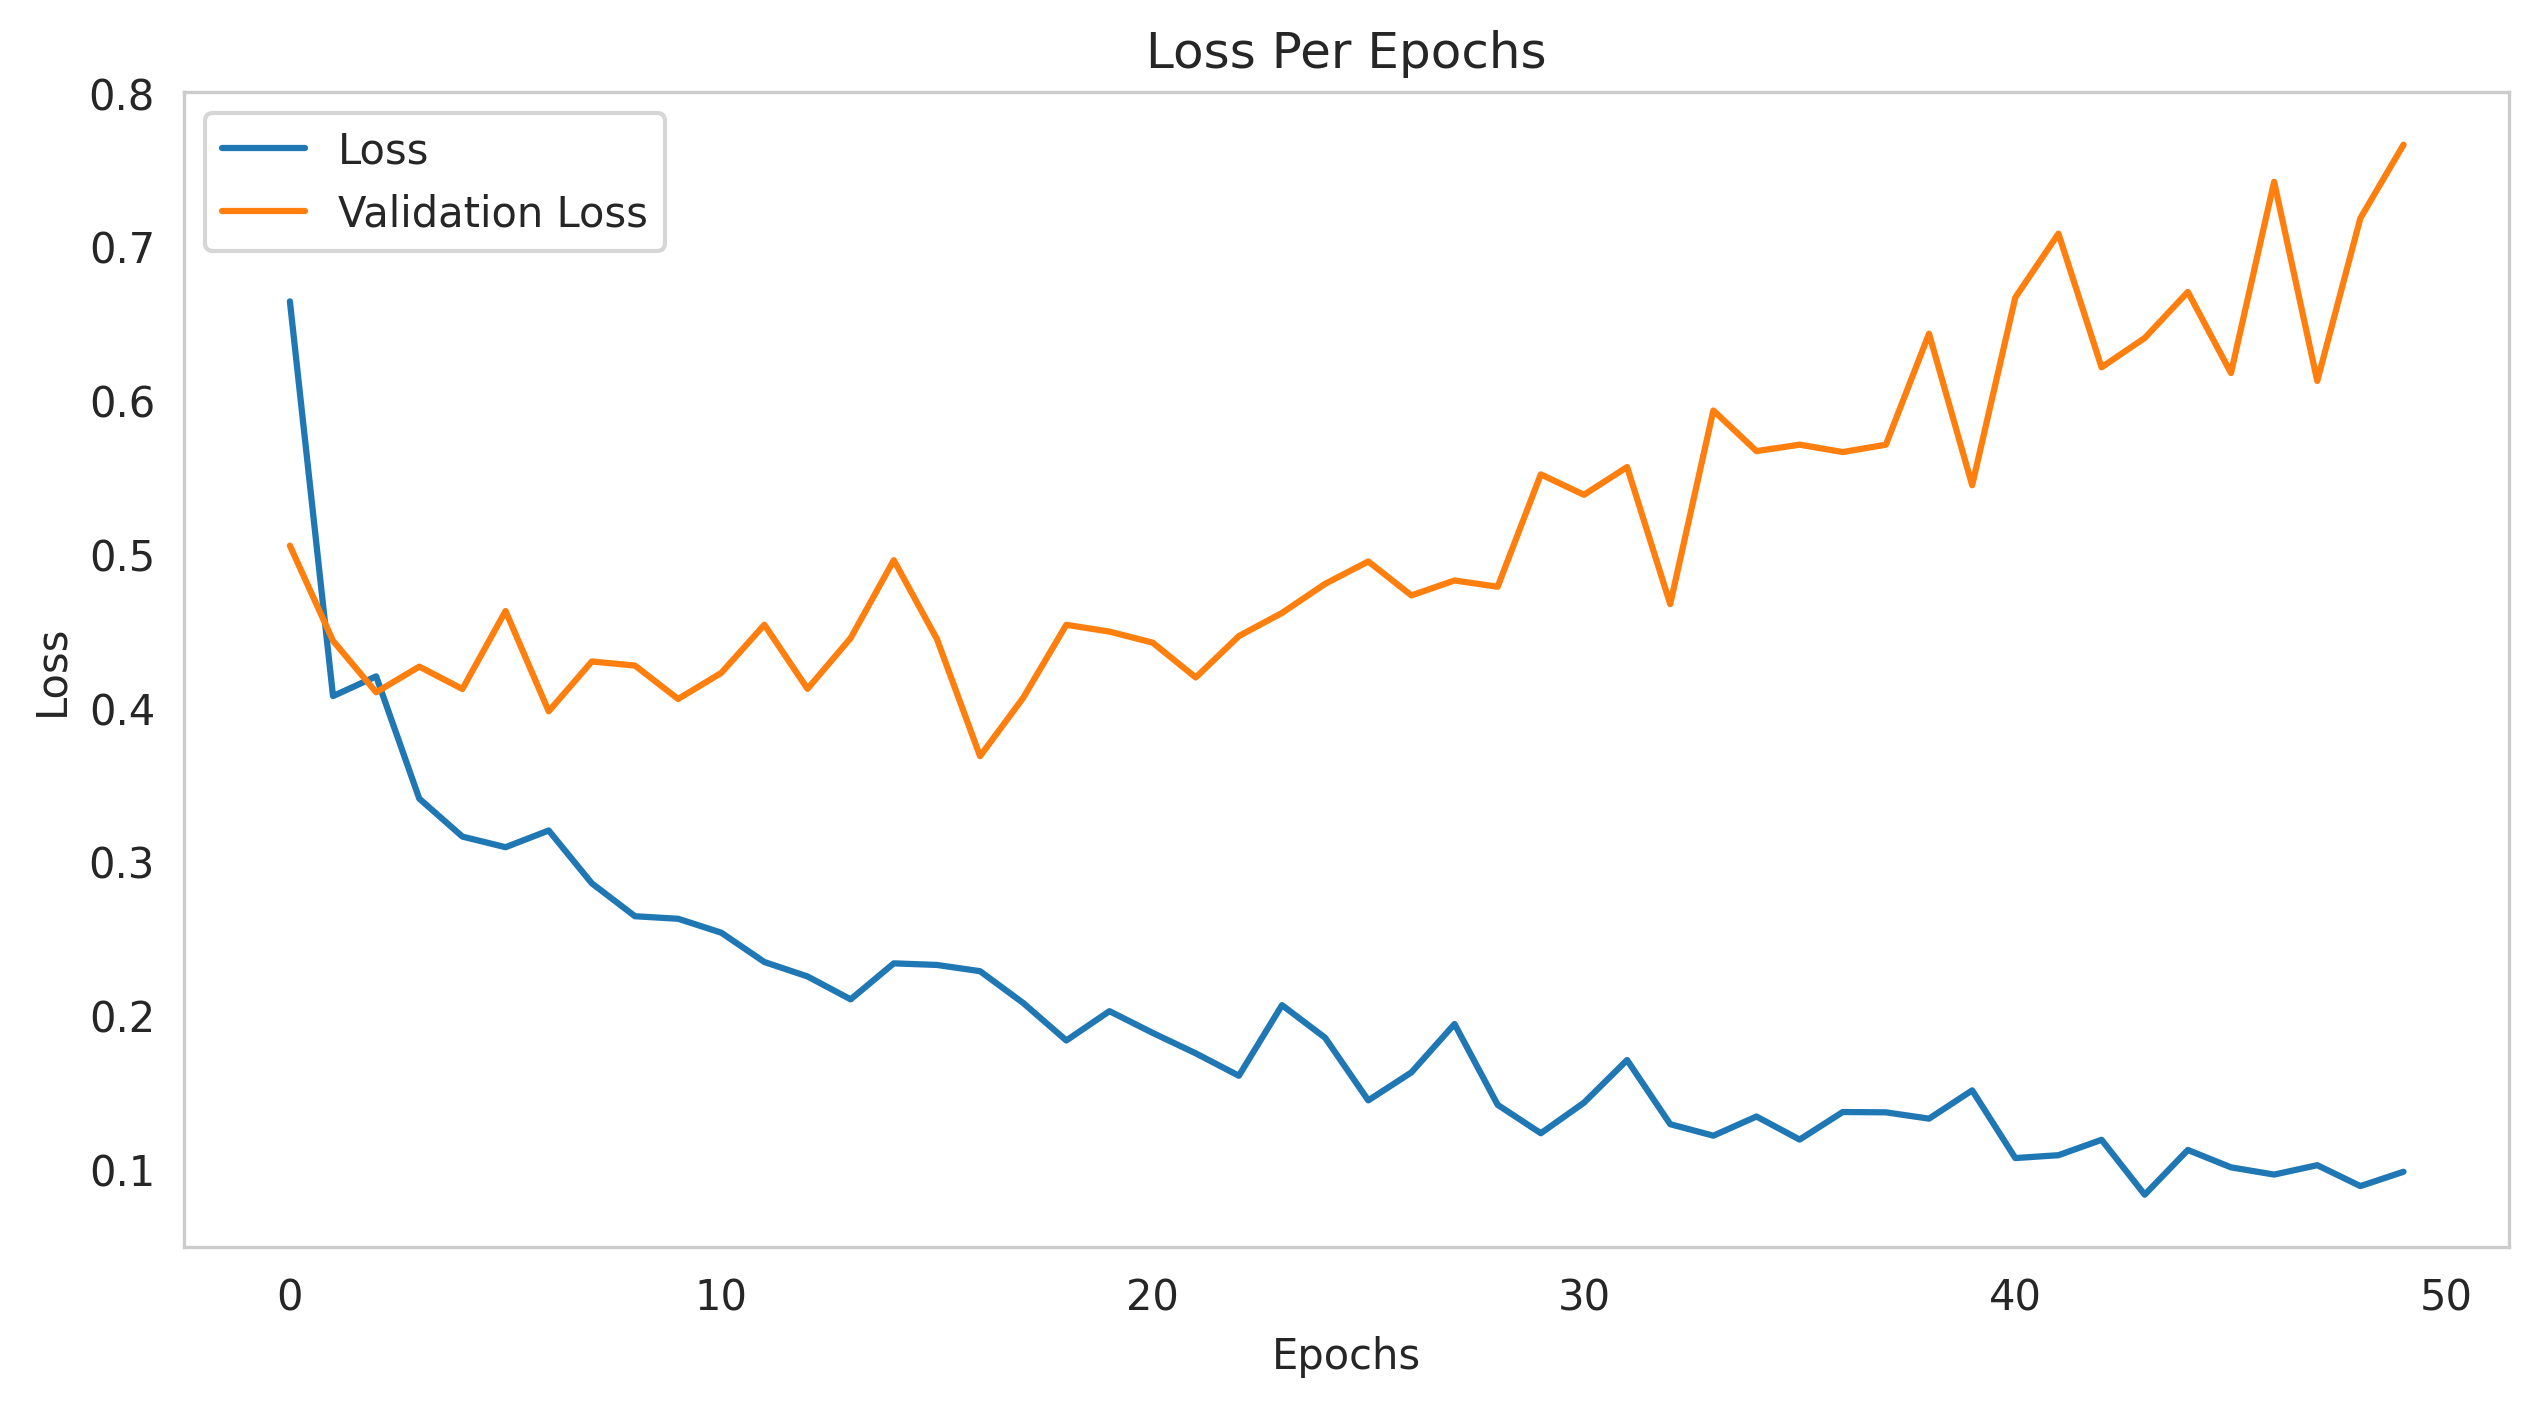

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_cnn2d[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# this is categorical/multiclass cross-entropy loss

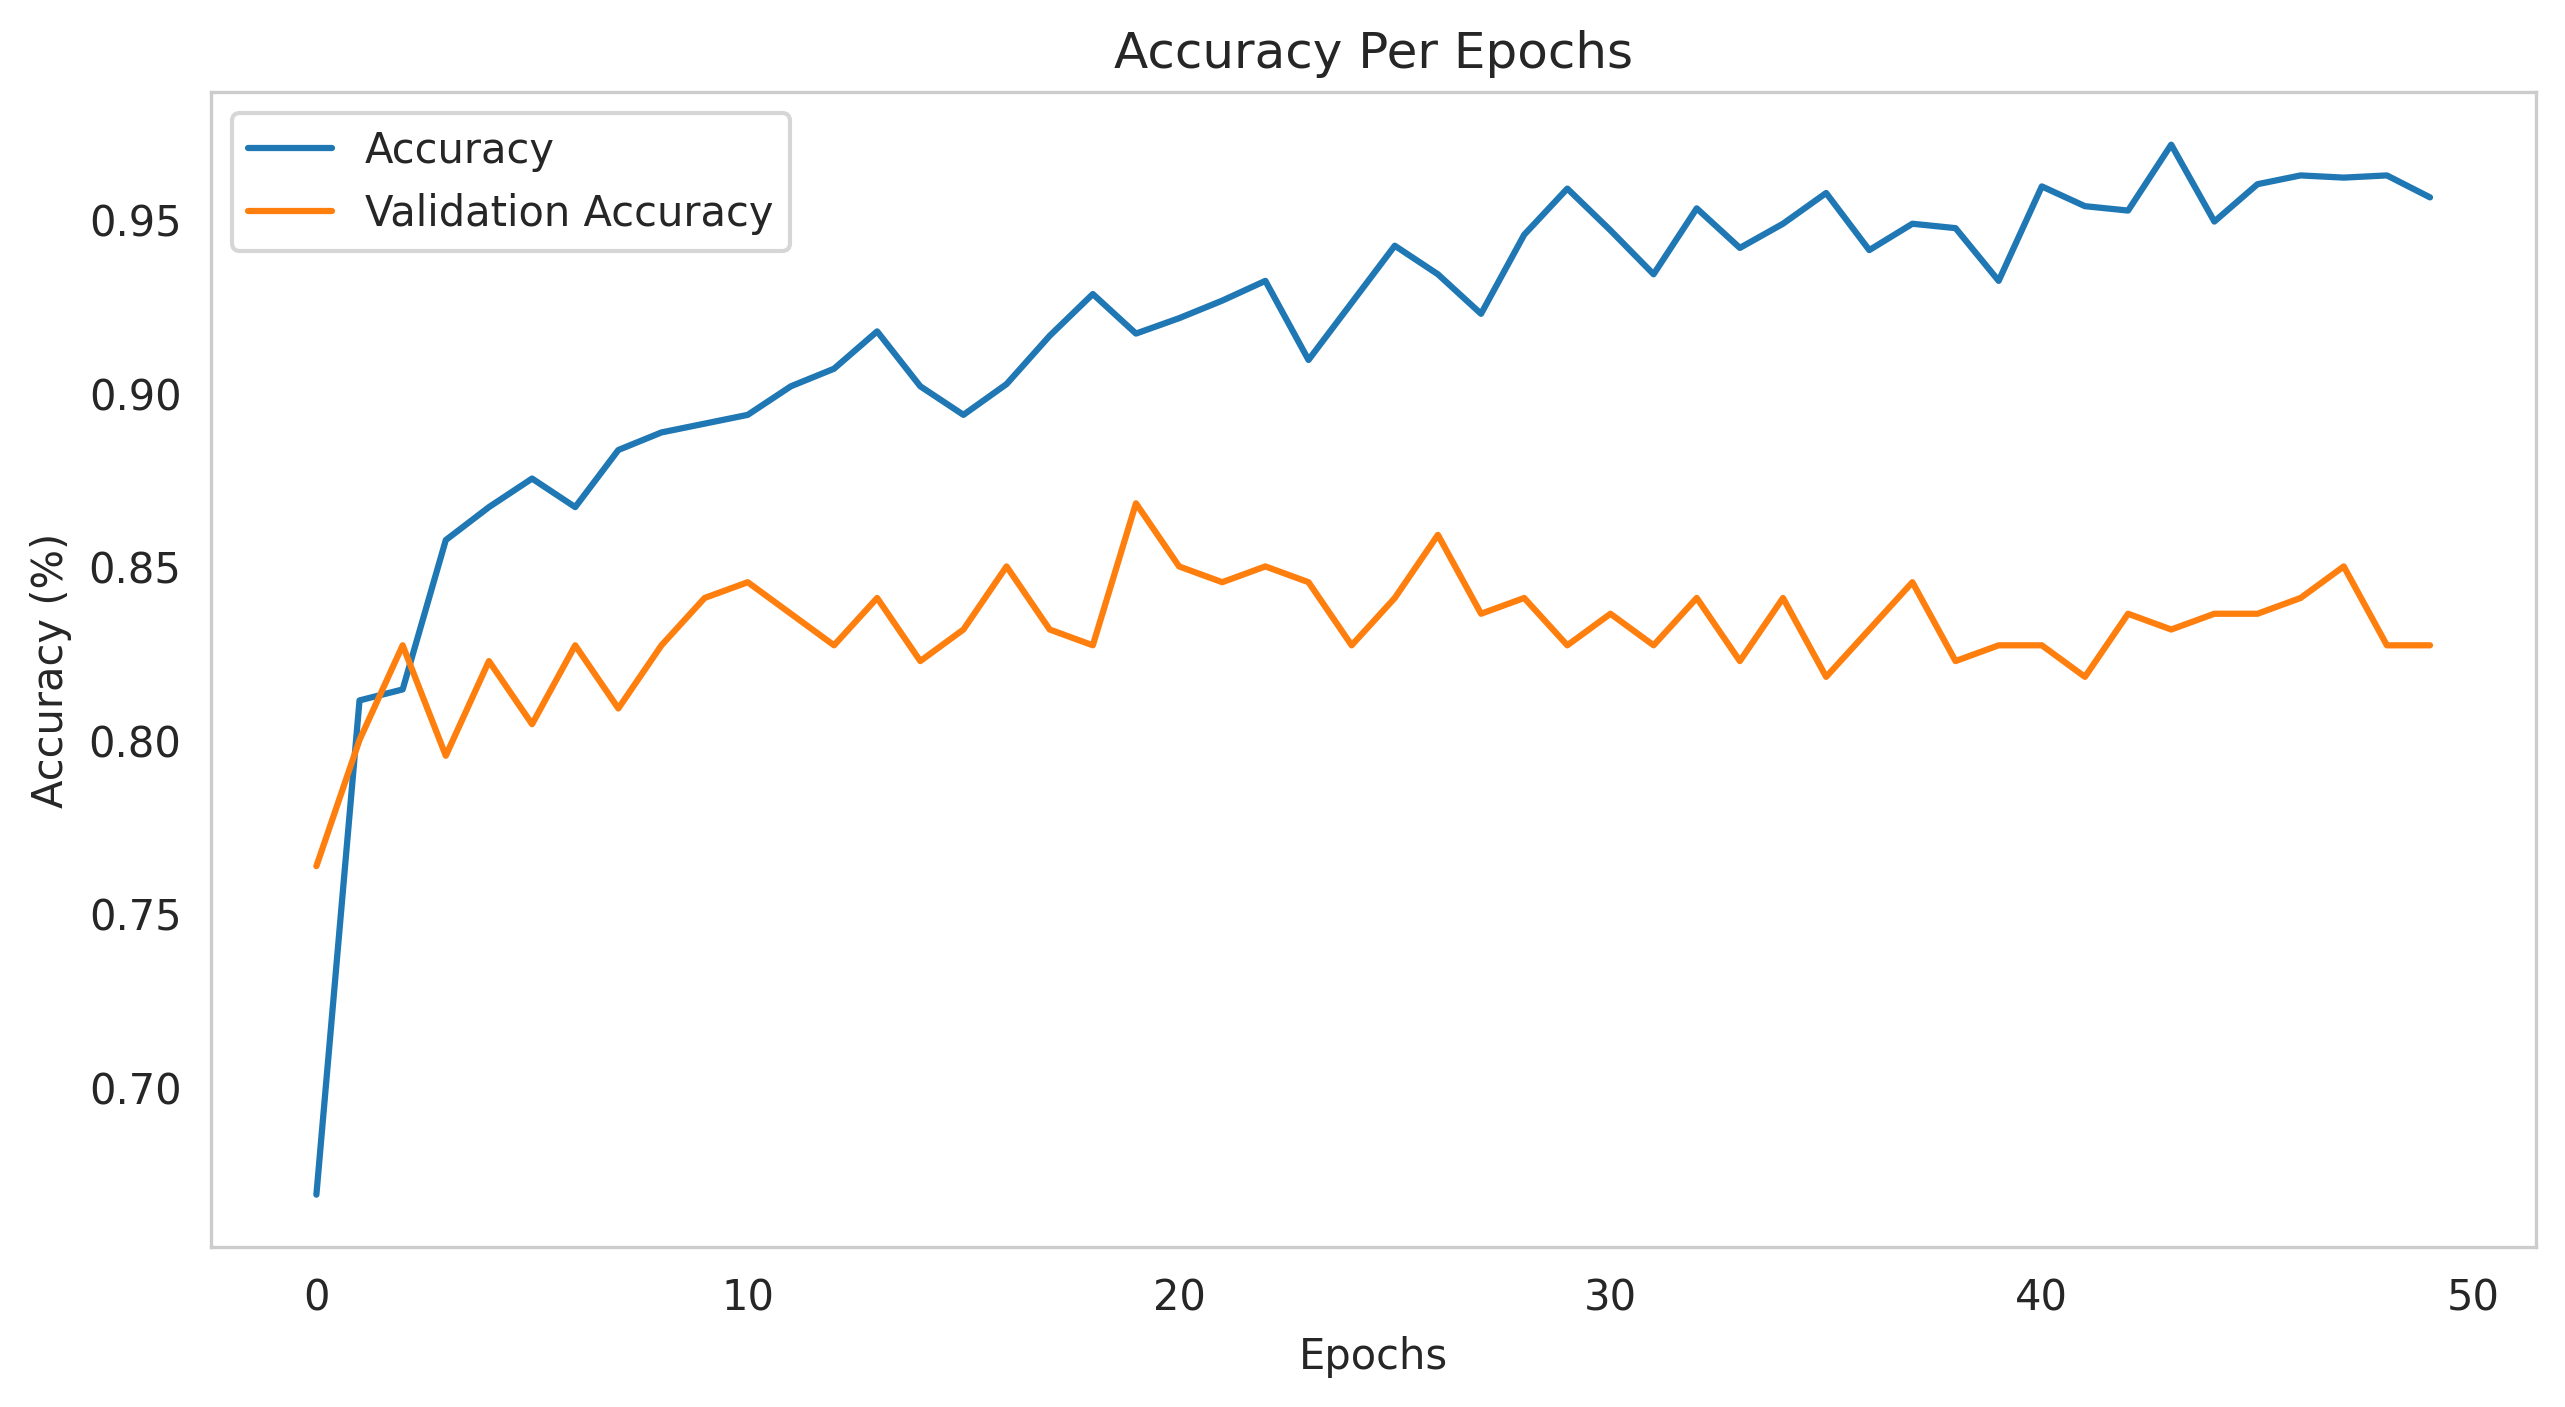

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_cnn2d[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"]) # training accuracy, test accuracy
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
accuracy_cnn2d = model_cnn2d.evaluate(xtest, yTest, verbose=0) # evaluates and returns a list of metrics, but doesn't print output (verbose=0)
t0 = time.time() # records time before making preds
y_pred_cnn2d = model_cnn2d.predict(xtest, verbose=0) # predicts labels for test data (xtest)
pred_cnn2d = round(time.time() - t0, 3) # calcs time to make predictions; rounds to 3 decimals
log_entry = pd.DataFrame(
    [["CNN2D", accuracy_cnn2d[1] * 100, train_cnn2d, pred_cnn2d]], columns = col_names # accuracy_cnn2d[1] * 100 = accuracy of model on test data, to % format
) # train_cnn2d = training time, pred_cnn2d = pred time
log = pd.concat([log, log_entry], ignore_index=True) # concat is able to be used

In [ ]:
def cnn2d_pred(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast") # resampling type = kaiser fast
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=12) # 12 mfcc features extracted
    feature_scaled = np.mean(feature.T, axis = 0) # does the same thing as before; takes the mean of the feature matrix, resulting in a single value for each feature
    prediction_feature = np.array([feature_scaled]) # scaled features into numpy array
    final_prediction_feature = prediction_feature.reshape( # reshape to fit model; reshapes samples to have dimension (4, 3, 1)
        prediction_feature.shape[0], 4, 3, 1
    )
    predicted_vector = np.argmax(model_cnn2d.predict(final_prediction_feature), axis = -1) # argmax = index of the maximum value (predicted class ID)
    predicted_class = le.inverse_transform(predicted_vector) # converts ID back to class label

    print("CNN2D has predicted the class as  --> ", predicted_class[0])

In [ ]:
print(type(model_cnn2d))

<class 'keras.src.engine.sequential.Sequential'>


In [ ]:
file_name = dataset_path + "/trigger/f0003_0_sniff.wav"
cnn2d_pred(file_name)

ipd.Audio(file_name) # play the file

1/1 [==============================] - 0s 29ms/step
CNN2D has predicted the class as  -->  trigger


## Comparative Analysis

In [ ]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550
sns.set_style("whitegrid", {"axes.grid": False})

### Model Accuracy, Training, and Prediction

The CNN1D possessed the best accuracy of **87.8788%**.
* ANN followed closely behind with **85.9091%**.
* CNN2D was the worst with **82.7273%**.

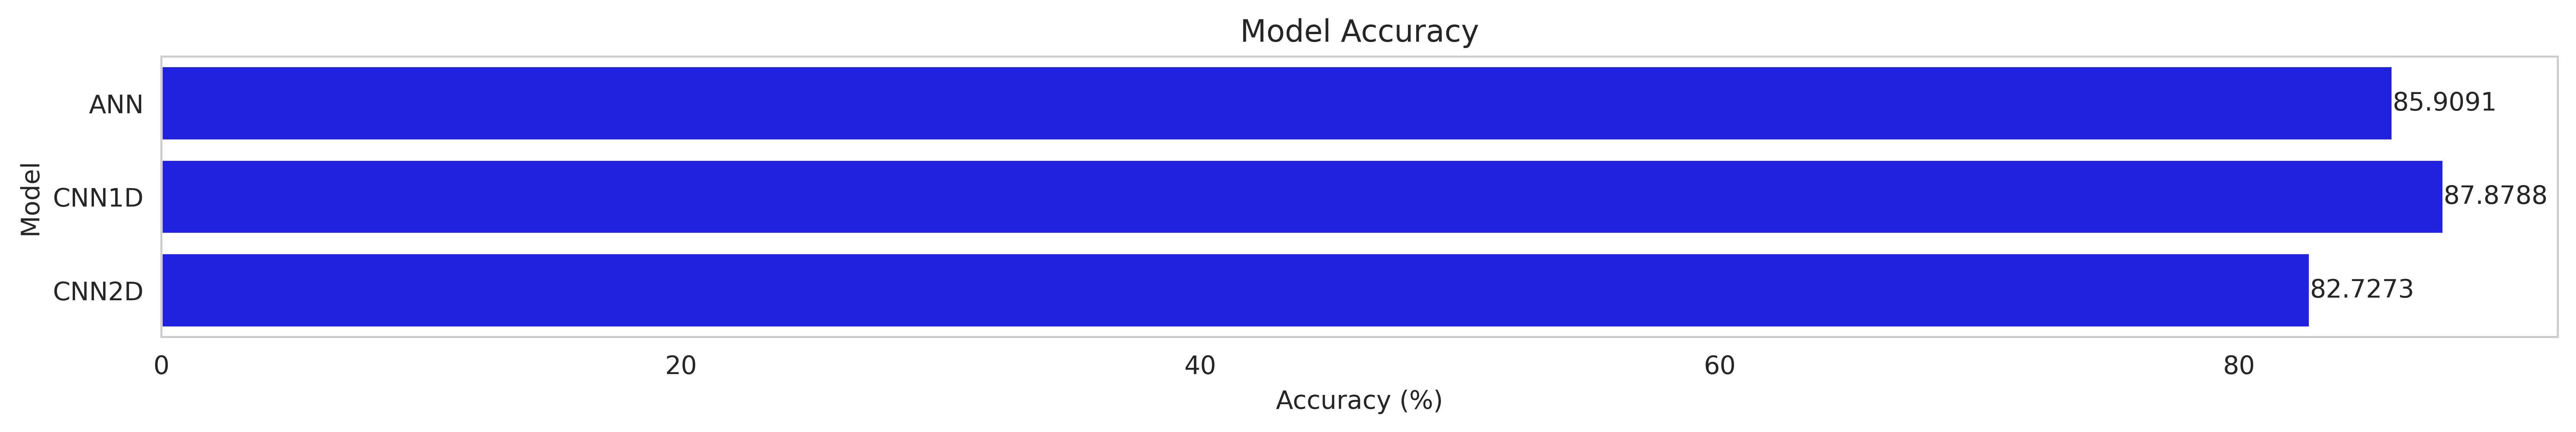

In [ ]:
ax = sns.barplot(x="accuracy", y="model", data=log, color="b", ci=None)
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

The CNN2D had the **least** training time with 9.616 seconds.
* The CNN1D had the second-lowest training time with 13.484 seconds.
* The CNN2D had the highest training time with 15.829 seconds.

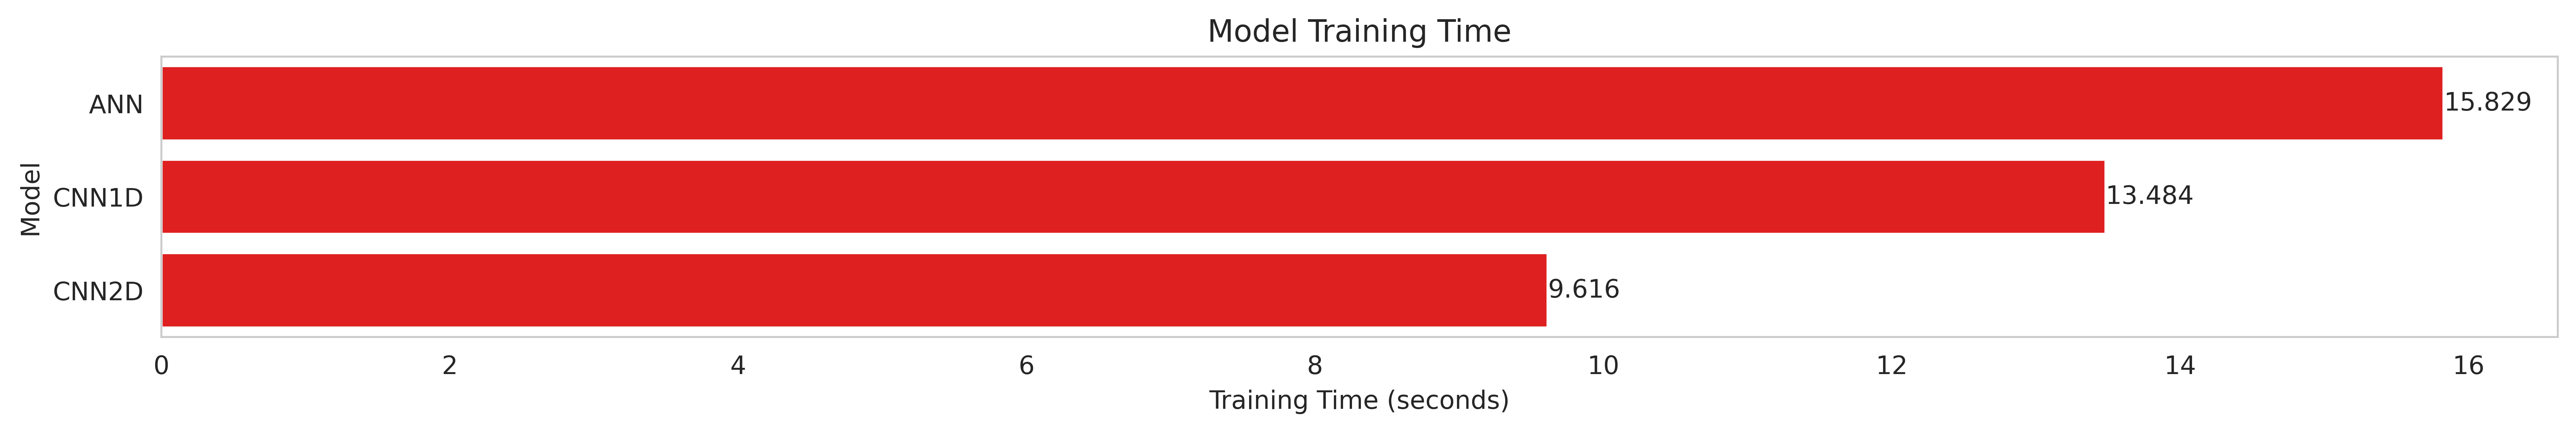

In [ ]:
ax = sns.barplot(x="train_time", y="model", data=log, color="r", ci=None)
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time (seconds)")
plt.ylabel("Model")
plt.title("Model Training Time")
plt.show()

The CNN2D had the **lowest** prediction time with 0.129 seconds.
* The ANN had the second-lowest prediction time with 0.166 seconds.
* The CNN1D had the highest prediction time with 0.205 seconds.

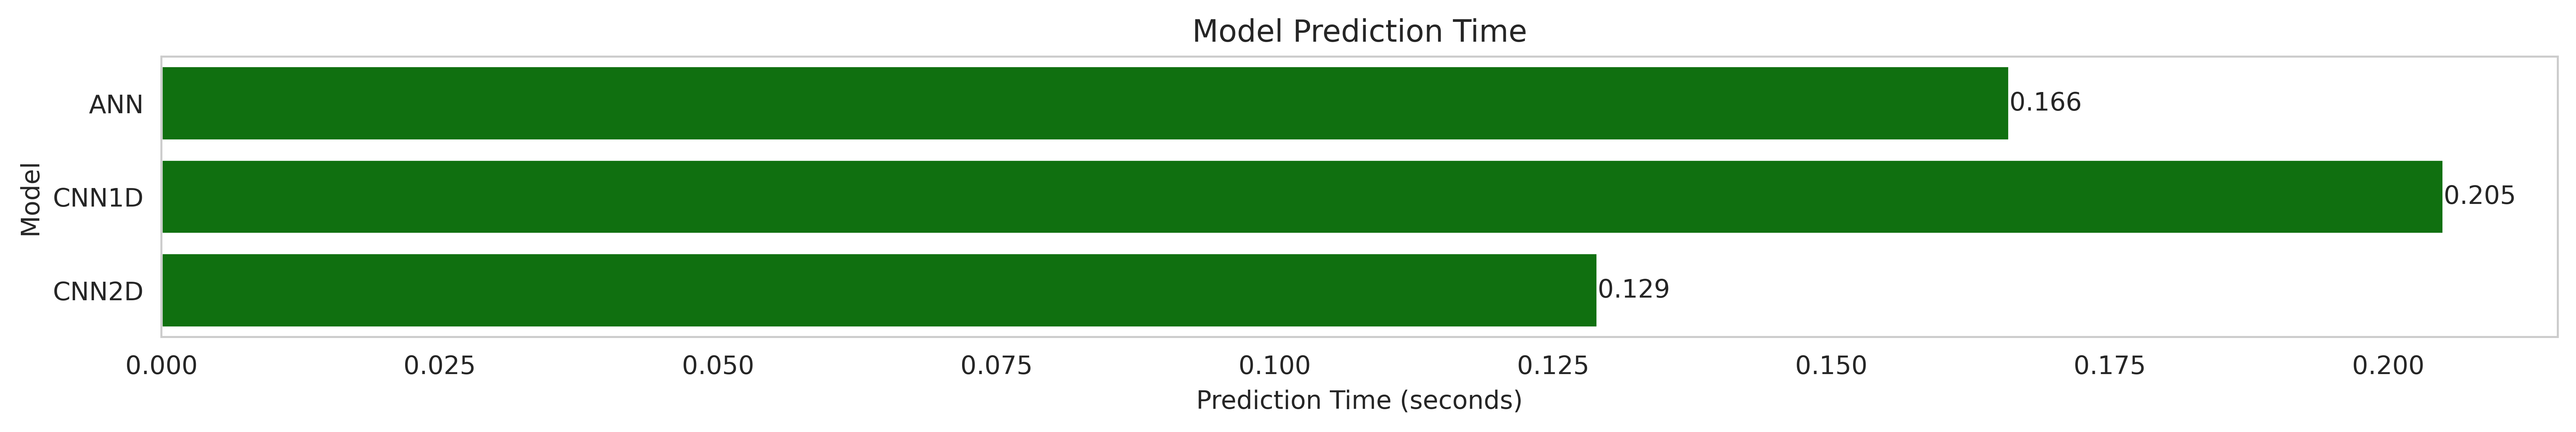

In [ ]:
ax = sns.barplot(x="pred_time", y="model", data=log, color="g", ci=None)
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time (seconds)")
plt.ylabel("Model")
plt.title("Model Prediction Time")
plt.show()

## Confusion Matrix
While we have the graphs for each metric, let's look at the confusion matrix for each model's accuracy.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

xTest_reshaped = np.expand_dims(xTest, axis = -1)

y_pred_ann = model_ann.predict(X_test)
y_pred_cnn1 = model_cnn1d.predict(xTest_reshaped)
y_pred_cnn2 = model_cnn2d.predict(xtest)

7/7 [==============================] - 0s 3ms/step


In [ ]:
y_pred_classes_ann = np.argmax(y_pred_ann, axis = 1)
y_true_classes_ann = np.argmax(y_test, axis = 1)

y_pred_classes_cnn1 = np.argmax(y_pred_cnn1, axis = 1)
y_true_classes_cnn1 = np.argmax(yTest, axis = 1)

y_pred_classes_cnn2 = np.argmax(y_pred_cnn2, axis = 1)
y_true_classes_cnn2 = np.argmax(yTest, axis = 1)

In [ ]:
cm_ann = confusion_matrix(y_true_classes_ann, y_pred_classes_ann)
cm_cnn1 = confusion_matrix(y_true_classes_cnn1, y_pred_classes_cnn1)
cm_cnn2 = confusion_matrix(y_true_classes_cnn2, y_pred_classes_cnn2)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels = le.classes_)
disp_cnn1 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn1, display_labels = le.classes_)
disp_cnn2 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn2, display_labels = le.classes_)

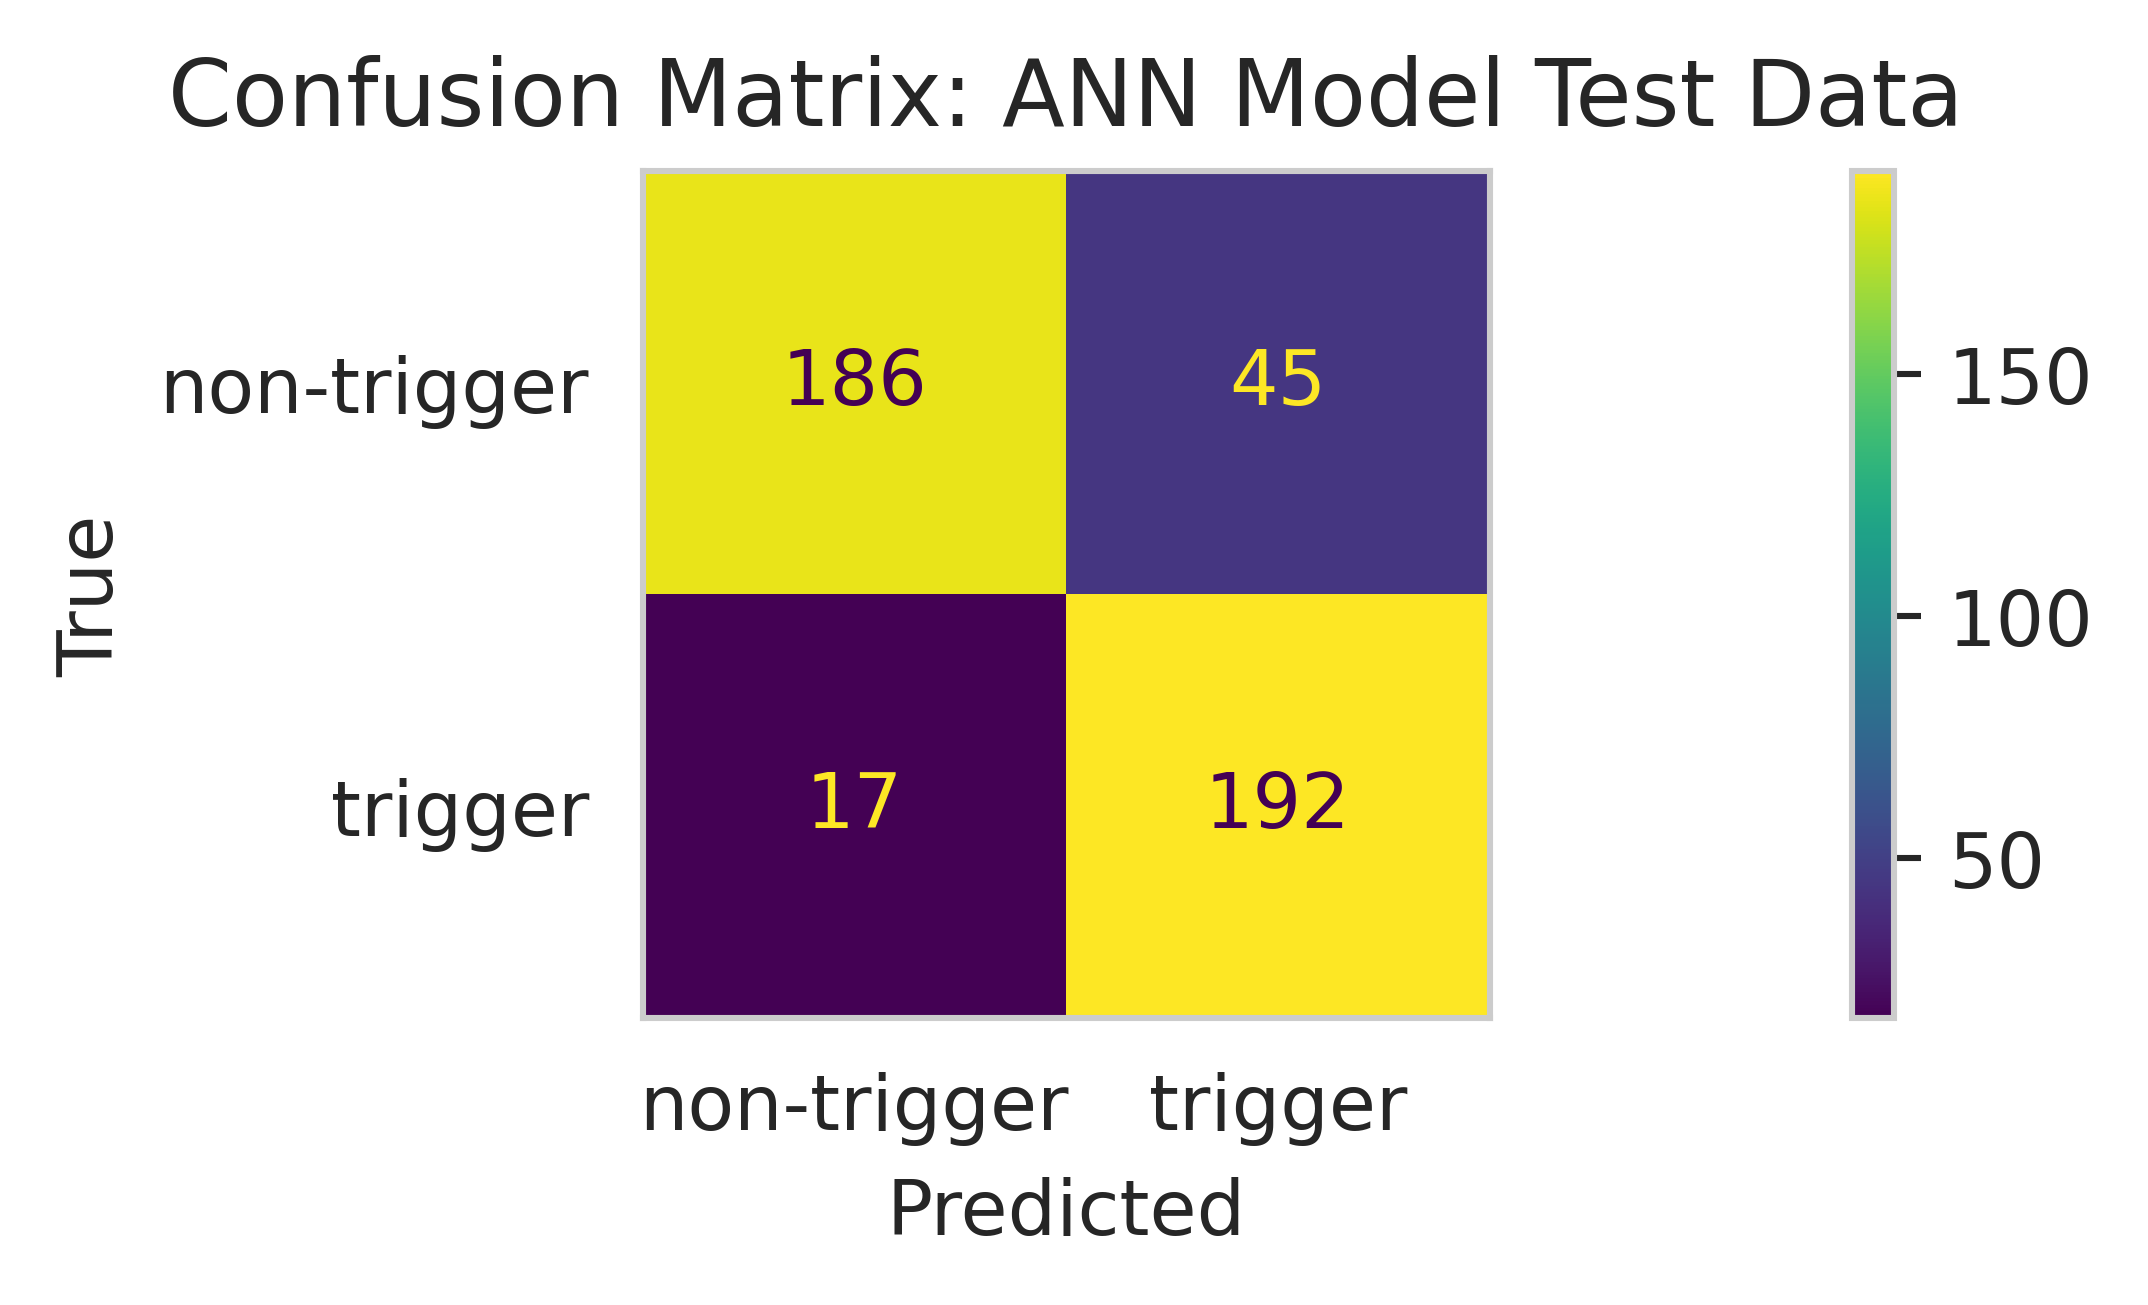

In [ ]:
disp_ann.plot()
plt.title('Confusion Matrix: ANN Model Test Data')
disp_ann.ax_.set(xlabel='Predicted', ylabel='True')
plt.show()

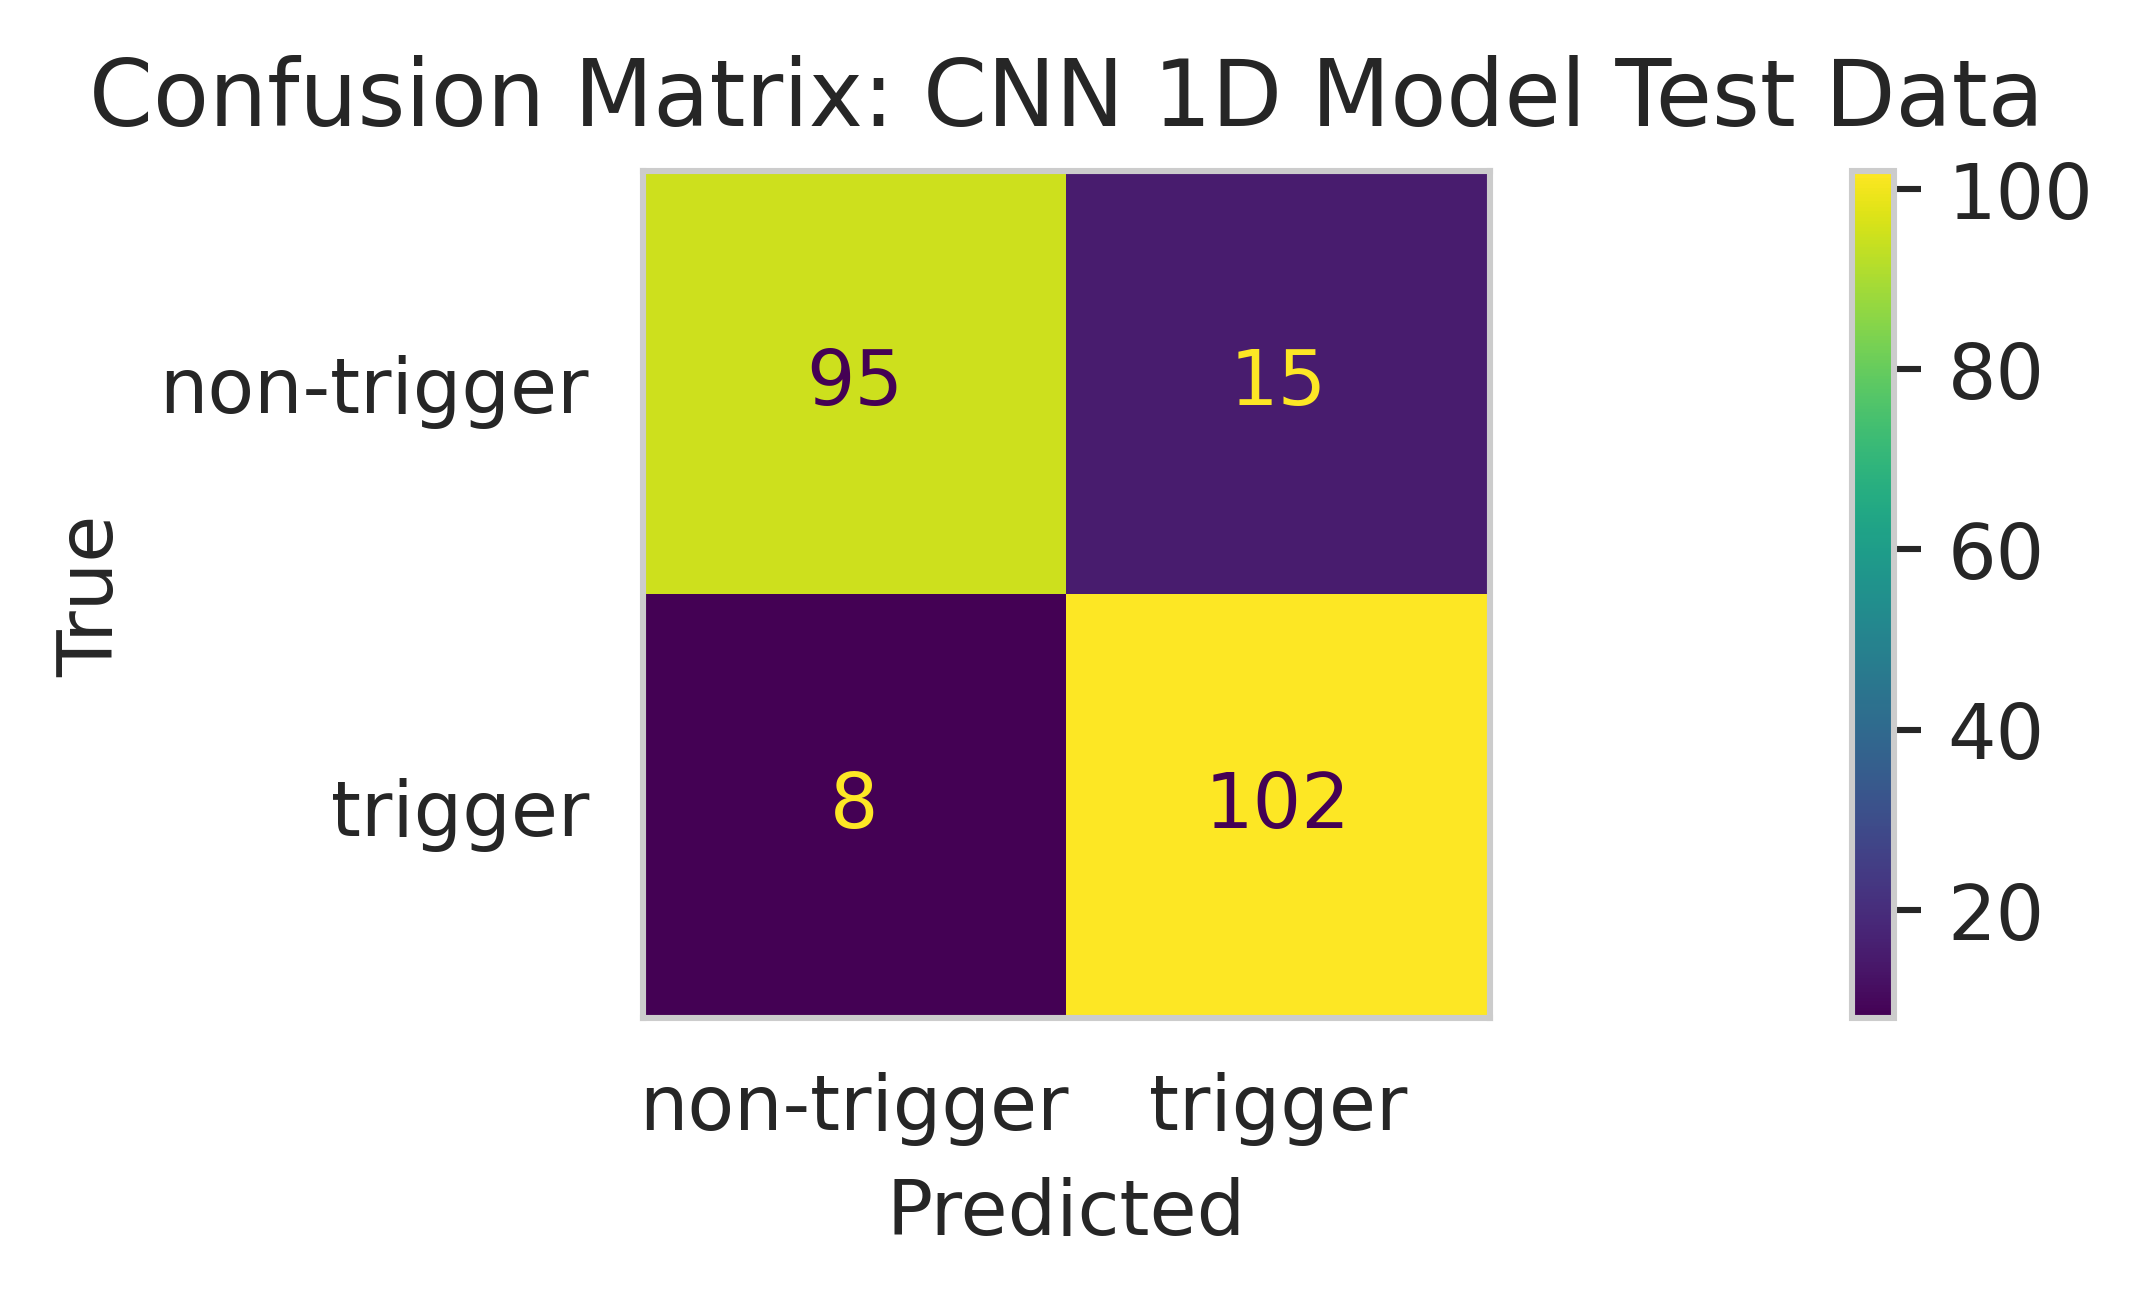

In [ ]:
disp_cnn1.plot()
plt.title('Confusion Matrix: CNN 1D Model Test Data')
disp_cnn1.ax_.set(xlabel='Predicted', ylabel='True')
plt.show()

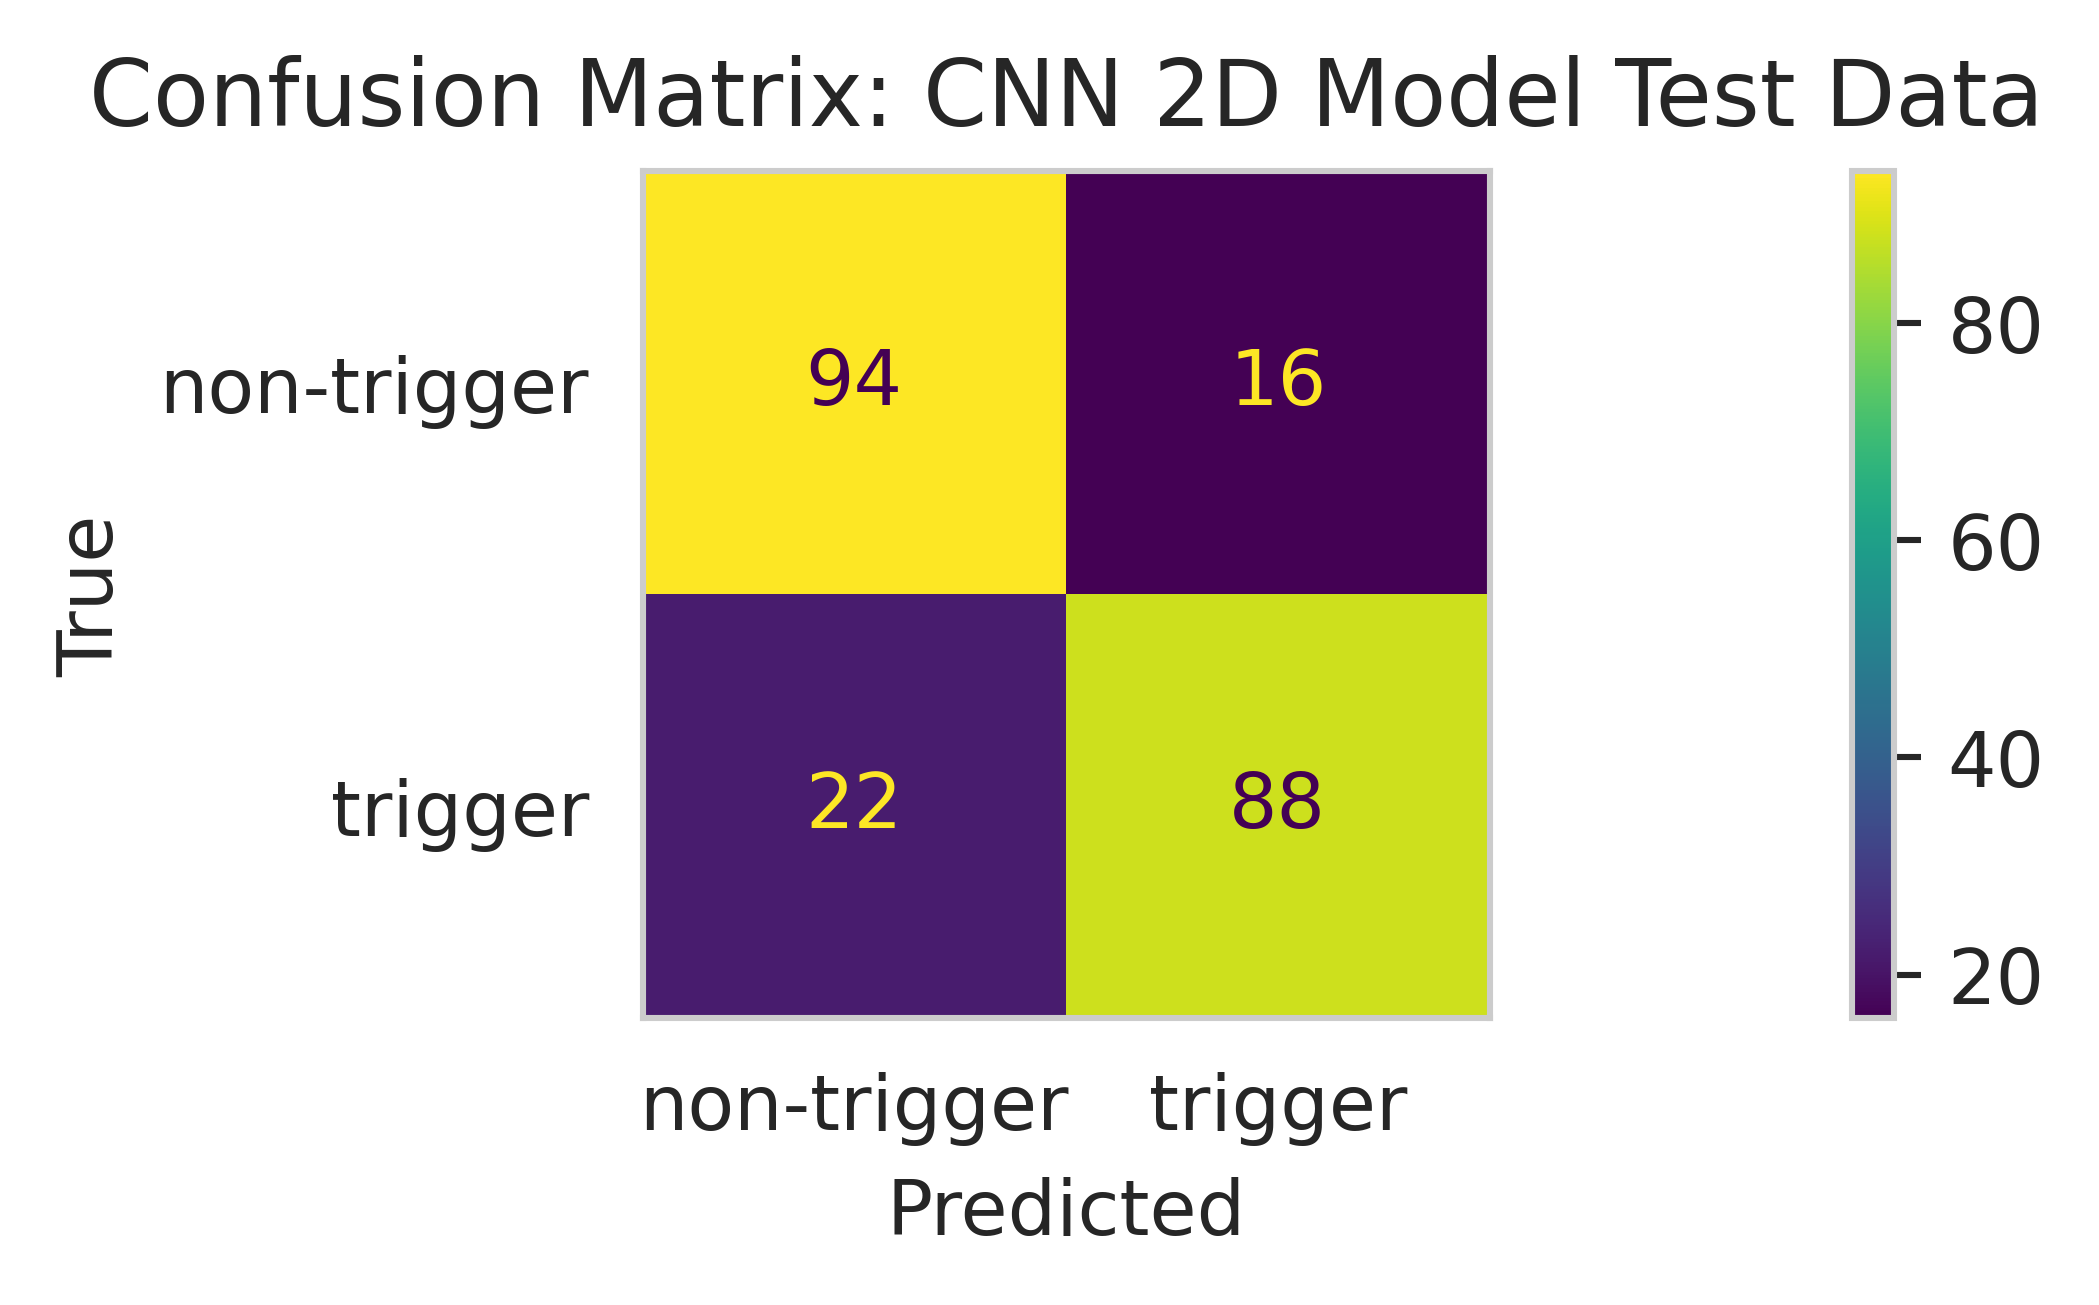

In [ ]:
disp_cnn2.plot()
plt.title('Confusion Matrix: CNN 2D Model Test Data')
disp_cnn2.ax_.set(xlabel='Predicted', ylabel='True')
plt.show()

These confusion matrixes line up with the accuracy percentages.